# PENGUJIAN

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/Colab Notebooks/neonormal

ModuleNotFoundError: No module named 'google.colab'

## Import Library

In [16]:
pip install -i https://test.pypi.org/simple/ neonormal==0.1.15

Looking in indexes: https://test.pypi.org/simple/


In [ ]:
pip install -i https://test.pypi.org/simple/ neonormal

Looking in indexes: https://test.pypi.org/simple/


In [4]:
from neonormal import fsst, msnburr, msnburr_iia
from neonormal import fsst_family, msnburr_family,msnburr_iia_family

In [5]:
import pymc as pm
import numpy as np
import arviz as az
import xarray as xr
import pytensor.tensor as pt
import pytensor
import matplotlib.pyplot as plt
import scipy.stats as st
import math
import scipy
import seaborn as sns
import bambi as bmb
import pandas as pd

In [6]:
sampler_kwargs = {
    "chains": 4,
    "cores": 4,
    "return_inferencedata": True,
    "random_seed": 42,
}

## Uji Coba Fungsi

###Quantile

In [7]:
mu = pt.scalar('mu')
sigma = pt.scalar('sigma')
nu = pt.scalar('nu')
alpha = pt.scalar('alpha')
p = pt.scalar('p')

# Definisikan fungsi ICDF sebagai tensor operation
rv_quantile = fsst.icdf(p, mu, sigma, nu, alpha)
q = rv_quantile.eval({p: 0.9, mu: 0.0, sigma:1, nu: 1, alpha:2})
print(f"Quantile eval:", q)

# Kompilasi fungsi ICDF agar bisa dipakai dalam PyMC
rv_quantile_fn = pm.compile([p, mu, sigma, nu, alpha], rv_quantile)

# Uji dengan nilai tertentu
q_pymc = rv_quantile_fn(p=0.9, mu=0.0, sigma=1.0, nu=1, alpha=2.0)
print(f"Quantile dihitung dengan PyMC:", q_pymc)

Quantile eval: 10.054678984251698
Quantile dihitung dengan PyMC: 10.054678984251698


### PDF

Uji coba nilai probabilitas

In [8]:
mu = pt.scalar('mu')
sigma = pt.scalar('sigma')
nu = pt.scalar('nu')
alpha = pt.scalar('alpha')
x = pt.scalar('x')
p = pt.scalar('p')

rv = fsst.dist(mu=mu, sigma=sigma, nu=nu, alpha=alpha)

logp_expr = pm.logp(rv, x)
pdf = np.exp(logp_expr.eval({mu: 0.0, sigma: 1.0, nu: 5, alpha: 2, x: 0.5}))

logcdf_expr = pm.logcdf(rv, x)
cdf = np.exp(logcdf_expr.eval({mu: 0.0, sigma: 1.0, nu: 5, alpha: 2, x: 0.5}))

quantile_expr = fsst.icdf(p, mu, sigma, nu, alpha)
quantile = quantile_expr.eval({p: 0.9, mu: 0.0, sigma: 1.0, nu: 5, alpha: 2})

print("PDF        :", pdf)
print("CDF        :", cdf)
print("Quantile   :", quantile)

PDF        : 0.29257603412475464
CDF        : 0.34997269540470144
Quantile   : 3.681835316402445


In [11]:
# Definisi variabel simbolik
mu = pt.scalar('mu')
sigma = pt.scalar('sigma')
alpha = pt.scalar('alpha')
nu = pt.scalar('nu')
value = pt.scalar('value')

rv = fsst.dist(mu=mu, sigma=sigma, nu=nu, alpha=alpha)
rv_logp = pm.logp(rv, value)

# Menggunakan .eval() untuk debugging
p=(rv_logp.eval({value:0.5, mu: 0, sigma:1, nu: 1, alpha:2}))
print(math.exp(p))

# Compile fungsi agar bisa dievaluasi berulang kali
rv_logp_fn = pm.compile_pymc([value, mu, sigma, nu, alpha], rv_logp)
q = rv_logp_fn(value=0.9, mu=0, sigma=-1, nu=2, alpha=2)
print(q)

0.2396686201854424
-inf


/usr/local/lib/python3.11/dist-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


In [ ]:
rv = fsst.dist(mu=mu, sigma=sigma, nu=nu, alpha=alpha)
rv_logp = pm.logp(rv, value)

p=(rv_logp.eval({value:0.5, mu: 0, sigma:1, nu: 1, alpha:2}))
print(math.exp(p))

0.2396686201854424


Visualisasi dengan plot

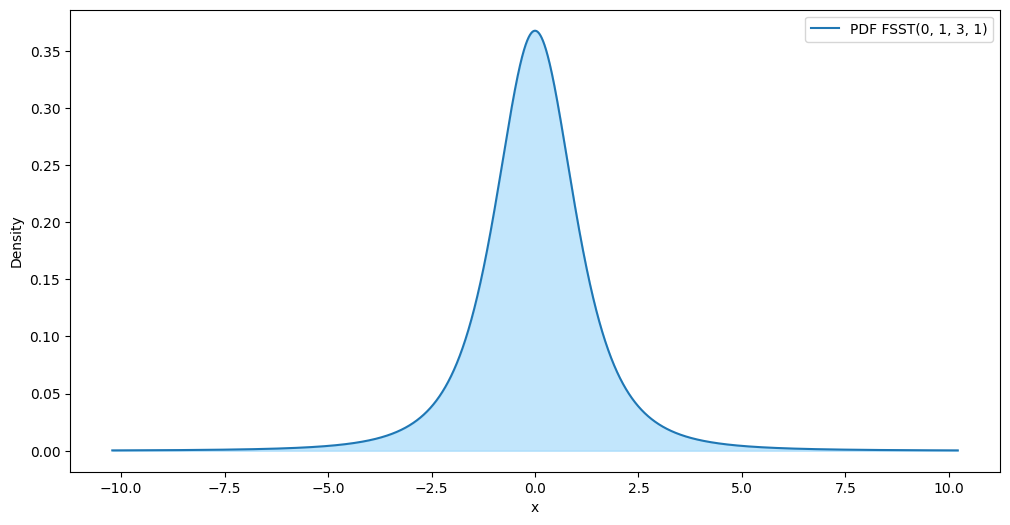

In [ ]:
alpha    = 1
mu       = 0
nu       = 3
sigma    = 1

# # Mmebuat batas menggunakan kuantil
q_low = rv_quantile_fn(p=0.001, mu=mu, sigma=sigma, nu=nu, alpha=alpha)
q_high = rv_quantile_fn(p=0.999, mu=mu, sigma=sigma, nu=nu, alpha=alpha)
x = np.linspace(q_low, q_high, 10000)

y = np.exp([rv_logp_fn(value=xi, mu=mu, sigma=sigma, nu=nu, alpha=alpha) for xi in x])

plt.figure(figsize=(12, 6))
plt.plot(x, y, label=f'PDF FSST({mu}, {sigma}, {nu}, {alpha})')

plt.xlabel("x")
plt.ylabel("Density")
plt.legend(loc="upper left")
plt.fill_between(x, y, color="lightskyblue", alpha=0.5)
plt.legend(loc='best')
plt.show()

Uji coba PDF dengan berbagai nilai parameter

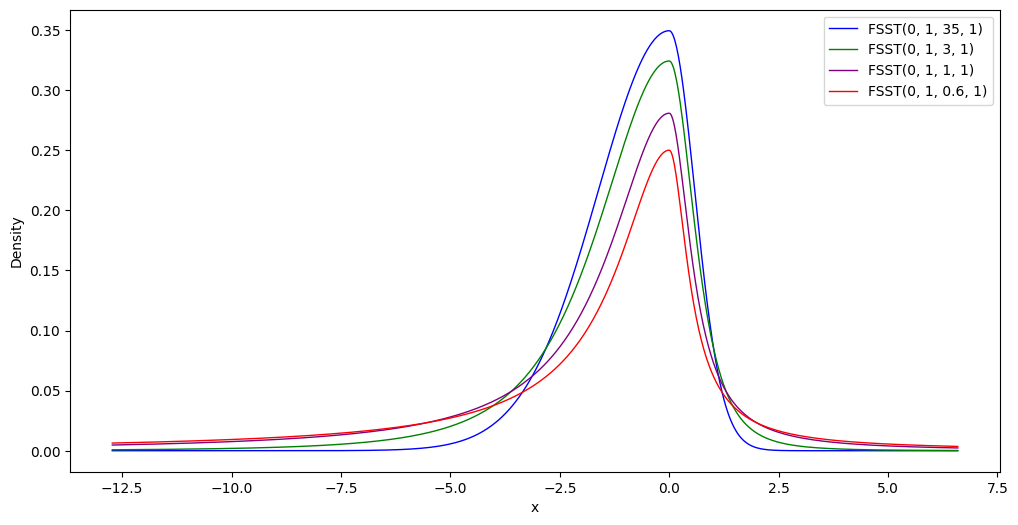

In [ ]:
# Mmebuat batas menggunakan kuantil
q_low = rv_quantile_fn(p=0.005, mu=0.0, sigma=1.0, nu=1, alpha=2.0)
q_high = rv_quantile_fn(p=0.85, mu=0.0, sigma=1.0, nu=1, alpha=2.0)
x = np.linspace(q_low, q_high, 1000)

# # Beda sigma
# y1 = st.norm.pdf(x, mu, sigma)
# y2 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=1.0, nu=1.0, alpha=1.0) for xi in x])
# y3 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=2.0, nu=1.0, alpha=1) for xi in x])
# y4 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=3.0, nu=1.0, alpha=1) for xi in x])
# y5 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=0.8, nu=1.0, alpha=1.0) for xi in x])

# # Beda alpha/kemencengan
# y1 = st.t.pdf(x, 3, 0, 1.0)
# y2 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=1.0, nu=3, alpha=1.0) for xi in x])
# y3 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=1.0, nu=3, alpha=0.6) for xi in x])
# y4 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=1.0, nu=3, alpha=0.8) for xi in x])
# y5 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=1.0, nu=3, alpha=2.0) for xi in x])

# # Beda nu dengan kemencengan = 1
# y1 = st.norm.pdf(x, 0.0, 1.0)
# y2 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=1.0, nu=35, alpha=1.0) for xi in x])
# y3 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=1.0, nu=10, alpha=1.0) for xi in x])
# y4 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=1.0, nu=3, alpha=1.0) for xi in x])
# y5 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=1.0, nu=1, alpha=1.0) for xi in x])

# # Beda nu dengan menceng kanan/skewness = 2
# y1 = st.norm.pdf(x, 0.0, 1.0)
# y2 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=1.0, nu=35, alpha=2.0) for xi in x])
# y3 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=1.0, nu=3, alpha=2.0) for xi in x])
# y4 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=1.0, nu=1, alpha=2.0) for xi in x])
# y5 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=1.0, nu=0.6, alpha=2.0) for xi in x])

# #Beda nu dengan menceng kanan/skewness = 0.6
# y1 = st.norm.pdf(x, 0.0, 1.0)
y2 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=1.0, nu=35, alpha=0.6) for xi in x])
y3 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=1.0, nu=3, alpha=0.6) for xi in x])
y4 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=1.0, nu=1, alpha=0.6) for xi in x])
y5 = np.exp([rv_logp_fn(value=xi, mu=0.0, sigma=1.0, nu=0.6, alpha=0.6) for xi in x])

# Plot hasil uji PDF FSST
plt.figure(figsize=(12, 6))
# plt.plot(x, y1, label="Normal(0, 1)", color="orange",  linewidth=1.0)
plt.plot(x, y2, label="FSST(0, 1, 35, 1)", color="blue", linewidth=1.0)
plt.plot(x, y3, label="FSST(0, 1, 3, 1)", color="green", linewidth=1.0)
plt.plot(x, y4, label="FSST(0, 1, 1, 1)", color="purple", linewidth=1.0)
plt.plot(x, y5, label="FSST(0, 1, 0.6, 1)", color="red", linewidth=1.0)

plt.xlabel("x")
plt.ylabel("Density")
plt.legend(loc="best")
# plt.title("PDF FSST dengan Berbagai Nilai Alpha")
plt.show()


### CDF

Uji coba nilai kumulatif

In [9]:
mu = pt.scalar('mu')
sigma = pt.scalar('sigma')
alpha = pt.scalar('alpha')
nu = pt.scalar('nu')
value = pt.scalar('value')

rv = fsst.dist(mu=mu, sigma=sigma, nu=nu, alpha=alpha)
rv_logcdf = pm.logcdf(rv, value)

# Use .eval() for debugging
p=(rv_logcdf.eval({value: 13, mu: 0.6, sigma:0.7, nu: 4, alpha:5}))
print(p)

# Compile a function for repeated evaluations
rv_logcdf_fn = pm.compile_pymc([value, mu, sigma, nu, alpha], rv_logcdf)
q = rv_logcdf_fn(value=np.inf, mu=0, sigma=1, nu=2, alpha=1)
print(q)

-0.023299926831443028


/usr/local/lib/python3.11/dist-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


0.0


Visualisasi dengan plot

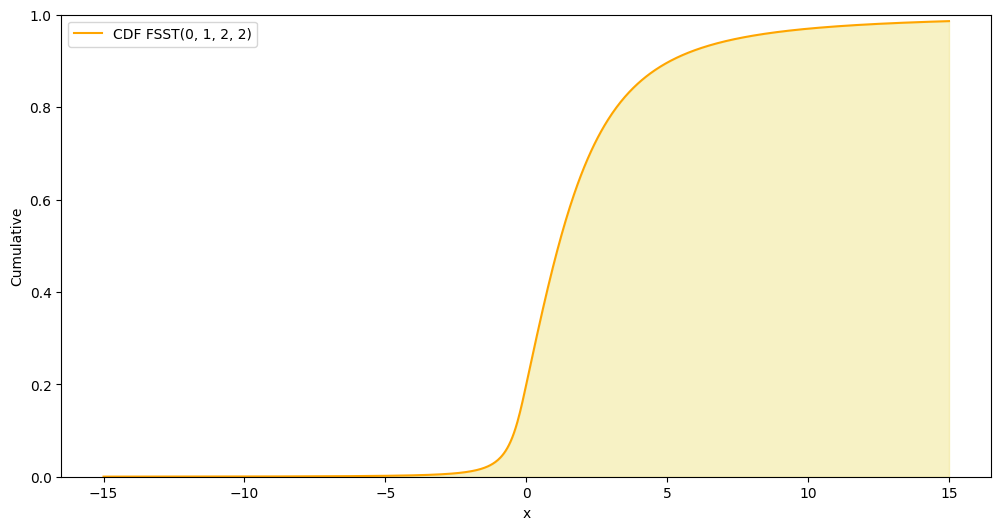

In [ ]:
x = np.linspace(-15, 15, 1000)

# Hitung nilai pdf
mu = 0
sigma = 1
nu = 2
alpha = 2
y = np.exp([rv_logcdf_fn(value=xi, mu=mu, sigma=sigma, nu=nu, alpha=alpha) for xi in x])

plt.figure(figsize=(12, 6))
plt.plot(x, y, label=f'CDF FSST({mu}, {sigma}, {nu}, {alpha})', color='orange')

plt.xlabel("x")
plt.ylabel("Cumulative")
plt.legend(loc="best")
plt.fill_between(x, y, color="khaki", alpha=0.5)
plt.ylim(0, 1)
plt.show()

Uji coba CDF dengan berbagai nilai parameter

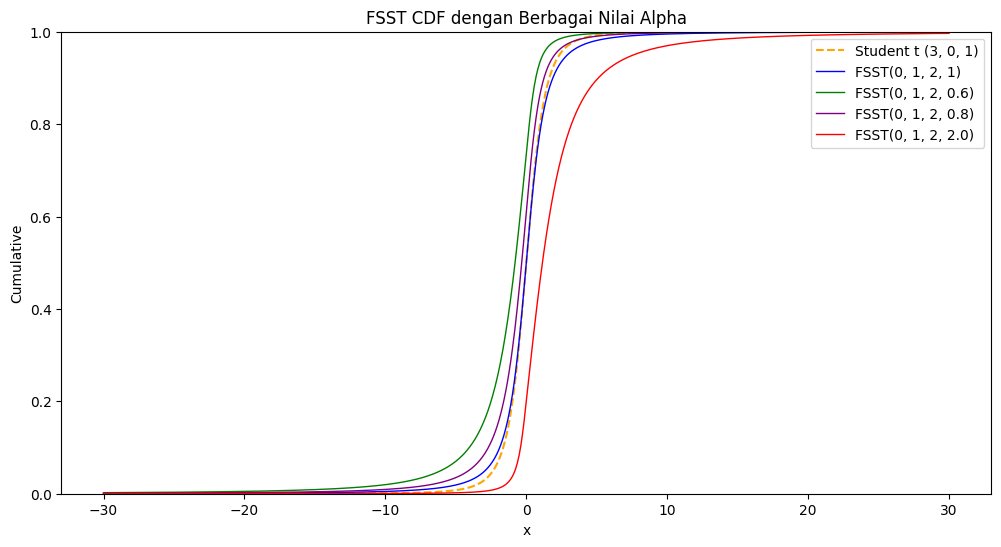

In [ ]:
# Parameter distribusi
mu = 0
sigma = 1
nu = 2  # Nilai default nu
x = np.linspace(-30, 30, 1000)  # Rentang data

# Menghitung PDF distribusi FSST untuk berbagai nilai alpha
y1 = st.t.cdf(x, 3, 0, 1.0)
y2 = np.exp([rv_logcdf_fn(value=xi, mu=0.0, sigma=1.0, nu=2.0, alpha=1.0) for xi in x])
y3 = np.exp([rv_logcdf_fn(value=xi, mu=0.0, sigma=1.0, nu=2.0, alpha=0.6) for xi in x])
y4 = np.exp([rv_logcdf_fn(value=xi, mu=0.0, sigma=1.0, nu=2.0, alpha=0.8) for xi in x])
y5 = np.exp([rv_logcdf_fn(value=xi, mu=0.0, sigma=1.0, nu=2.0, alpha=2.0) for xi in x])

# Plot hasil uji PDF FSST
plt.figure(figsize=(12, 6))
plt.plot(x, y1, label="Student t (3, 0, 1)", color="orange", linestyle="dashed")
plt.plot(x, y2, label="FSST(0, 1, 2, 1)", color="blue", linewidth=1.0)
plt.plot(x, y3, label="FSST(0, 1, 2, 0.6)", color="green", linewidth=1.0)
plt.plot(x, y4, label="FSST(0, 1, 2, 0.8)", color="purple", linewidth=1.0)
plt.plot(x, y5, label="FSST(0, 1, 2, 2.0)", color="red", linewidth=1.0)

plt.xlabel("x")
plt.ylabel("Cumulative")
plt.legend(loc="best")
plt.title("FSST CDF dengan Berbagai Nilai Alpha")
plt.ylim(0, 1)
plt.show()

### Random

In [ ]:
mu = 0
sigma = 1
nu = 3
alpha = 0.6

rv = fsst.dist(mu, sigma, nu, alpha)
hasilrandom = pm.draw(rv, draws=10000)

# print(type(hasilrandom))
print(hasilrandom)
print(f"Mean: {np.mean(hasilrandom)}")
print(f"Variance: {np.var(hasilrandom)}")
print(f"Skewness: {scipy.stats.skew(hasilrandom)}")

[-1.46186735  3.63981792  1.13882946 ... -0.62608831 -0.84264381
 -3.88896664]
Mean: -1.1806506888507222
Variance: 4.647927795287287
Skewness: -3.518316133058506


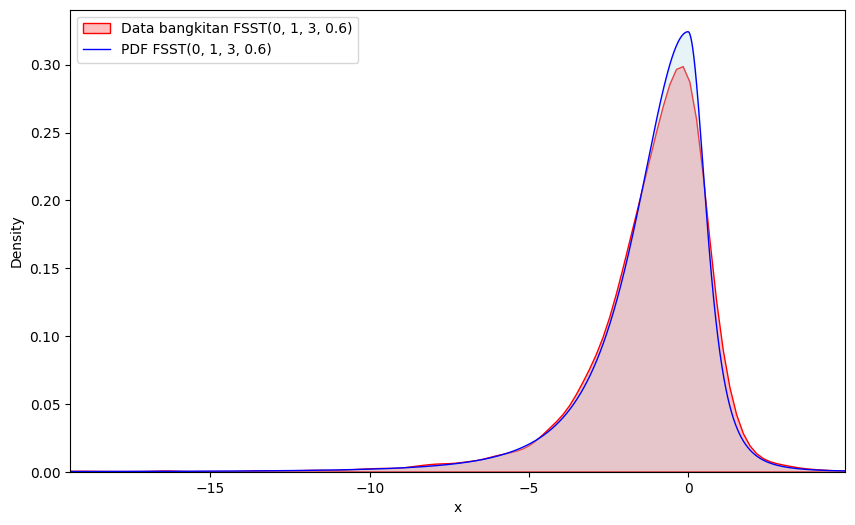

In [ ]:
# Batas menggunakan kuantil
q_low = float(rv_quantile_fn(p=0.001, mu=mu, sigma=sigma, nu=nu, alpha=alpha))
q_high = float(rv_quantile_fn(p=0.999, mu=mu, sigma=sigma, nu=nu, alpha=alpha))
x = np.linspace(q_low, q_high, 10000)

# # Batas menggunakan min dan max data random
# min_datarandom = np.min(hasilrandom)
# max_datarandom = np.max(hasilrandom)
# x = np.linspace(min_datarandom, max_datarandom, 100)

# Batas menggunakan angka
# x = np.linspace(-20, 20, 100)

plt.figure(figsize=(10, 6))
sns.kdeplot(hasilrandom, fill=True, color="red", label=f'Data bangkitan FSST({mu}, {sigma}, {nu}, {alpha})')
y2 = [np.exp(rv_logp_fn(value=xi, mu=mu, sigma=sigma, nu=nu, alpha=alpha)) for xi in x]

plt.plot(x, y2, label=f'PDF FSST({mu}, {sigma}, {nu}, {alpha})', color='blue', linewidth=1.0)
plt.fill_between(x, y2, color="lightblue", alpha=0.3)
plt.legend(loc="best")
plt.xlabel("x")
plt.ylabel("Density")
plt.xlim(q_low, q_high)
plt.show()


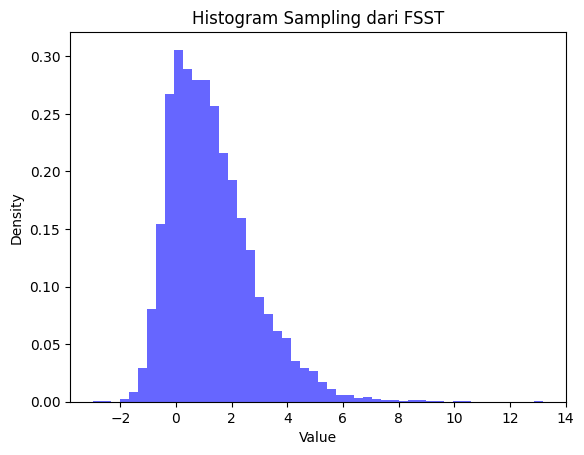

In [ ]:
mu = 0
sigma = 1
nu = 10
alpha = 2
n_samples = 5000

rv = fsst.dist(mu, sigma, nu, alpha)
sample_fsst = pm.draw(rv, draws=10000)


# Plot histogram hasil sampling
plt.hist(sample_fsst, bins=50, density=True, alpha=0.6, color='b')
plt.title("Histogram Sampling dari FSST")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()


##Validasi dengan R

In [13]:
import pandas as pd
# Menentukan parameter yang akan digunakan
mu_grup = [-10.45, -5, 0, 0.6, 9, 35]
sigma_grup = [0.1, 3, 10, 0.7, 8]
alpha_grup = [0.4, 0.7, 1, 5, 18]
nu_grup = [2, 4, 5, 7, 30, 48]
p_grup =[0.39, 0.51, 0.7, 0.88, 0.91]

# Nilai X yang akan dicari PDF dan CDFnya
x_grup = [-35, -29.5, -24, -5, -2.34, -10, 0, 3, 5.76, 7, 17.77, 20.22, 47, 77 ]

tabel_pdf = pd.DataFrame(columns=['X', 'mu', 'sigma','nu', 'alpha', 'logpdf', 'PDF'])
tabel_cdf = pd.DataFrame(columns=['X', 'mu', 'sigma','nu', 'alpha', 'logcdf', 'CDF'])
tabel_quantile = pd.DataFrame(columns=['p', 'mu', 'sigma','nu', 'alpha', 'quantile'])

import random
for i in range(0,25):
    mu = random.choice(mu_grup)
    sigma = random.choice(sigma_grup)
    nu = random.choice(nu_grup)
    alpha = random.choice(alpha_grup)
    x = random.choice(x_grup)
    p = random.choice(p_grup)
    logpdf = rv_logp_fn(value=x, mu=mu, sigma=sigma, nu=nu, alpha=alpha)
    logcdf = rv_logcdf_fn(value=x, mu=mu, sigma=sigma, nu=nu, alpha=alpha)
    kuantil = rv_quantile_fn(p=p, mu=mu, sigma=sigma, nu=nu, alpha=alpha)

    df_pdf = pd.DataFrame([{"X":x, "mu":mu, "sigma":sigma, "nu":nu, "alpha":alpha, 'logpdf':np.round(logpdf, decimals=5), "PDF":np.round(math.exp(logpdf), decimals = 5)}])
    df_cdf = pd.DataFrame([{"X":x, "mu":mu, "sigma":sigma, "nu":nu, "alpha":alpha, 'logcdf':np.round(logcdf, decimals=5), "CDF":np.round(math.exp(logcdf), decimals = 5)}])
    df_quantile = pd.DataFrame([{"p":p, "mu":mu, "sigma":sigma,"nu":nu, "alpha":alpha, 'quantile':np.round(kuantil, decimals=5)}])
    tabel_pdf = pd.concat([tabel_pdf, df_pdf], ignore_index=True)
    tabel_cdf = pd.concat([tabel_cdf, df_cdf], ignore_index=True)
    tabel_quantile = pd.concat([tabel_quantile, df_quantile], ignore_index=True)

tabel_pdf.to_excel('PDF.xlsx')
tabel_cdf.to_excel('CDF.xlsx')
tabel_quantile.to_excel('Quantile.xlsx')

/tmp/ipython-input-13-2180973174.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabel_pdf = pd.concat([tabel_pdf, df_pdf], ignore_index=True)
/tmp/ipython-input-13-2180973174.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabel_cdf = pd.concat([tabel_cdf, df_cdf], ignore_index=True)
/tmp/ipython-input-13-2180973174.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA 

##Validasi fungsi

###PDF

$$ \int_{-\infty}^{\infty} f(x) \, dx = 1 $$

In [ ]:
# FSST(0, 1, 1, 2)
pdf, error = scipy.integrate.quad(lambda x: np.exp(rv_logp_fn(value=x, mu=0, sigma=1, nu=1, alpha=2)), -np.inf, np.inf)
print(f'Hasil integral PDF = {pdf}')
print(f'Error = {error}')

Hasil integral PDF = 0.9999999999999978
Error = 9.409264166426734e-11


$$ P(X=c) = \int_c^c f(x) \, dx = 0 $$

In [ ]:
# FSST(0, 1, 1, 2) nilai PDF dengan x = 3
pdf, error = scipy.integrate.quad(lambda x: np.exp(rv_logp_fn(value=x, mu=0, sigma=1, nu=1, alpha=2)), 3, 3)
print(f'Hasil integral PDF = {pdf}')
print(f'Error = {error}')

Hasil integral PDF = 0.0
Error = 0.0


###CDF

$$ F(x) = P(X \leq x) = \int_{-\infty}^{x} f(t) \, dt $$

In [ ]:
# FSST(0, 1, 1, 2) nilai CDF untuk X <= 5

# Integral PDF dari -∞ sampai x=5
pdf, error = scipy.integrate.quad(lambda x: np.exp(rv_logp_fn(value=x, mu=0, sigma=1, nu=1, alpha=2)), -np.inf, 5)
print(f'CDF dari integral PDF= {pdf}')
print(f'Error PDF = {error}')

# Hitung CDF menggunakan fungsi logcdf
log_cdf_result = rv_logcdf_fn(5, 0, 1, 1, 2)
cdf_result = np.exp(log_cdf_result)

print(f'CDF dari logCDF = {cdf_result}')

# Cek selisih
diff = abs(pdf - cdf_result)
print(f'Selisih = {diff:.16f}')

CDF dari integral PDF= 0.8062096934548353
Error PDF = 1.085150291846304e-08
CDF dari logCDF = 0.8062096934546508
Selisih = 0.0000000000001845


$$ P(a \leq X \leq b) = \int_a^b f(x) \, dx = F(b) - F(a) $$

In [ ]:
# FSST(0, 1, 1, 2) nilai CDF untuk a = 1 dan b = 2

# Integral PDF dari x=1 sampai x=2
pdf, error = scipy.integrate.quad(lambda x: np.exp(rv_logp_fn(value=x, mu=0, sigma=1, nu=1, alpha=2)), 1, 2)
print(f'CDF dari integral PDF = {pdf}')
print(f'Error PDF = {error}')

# CDF dari a = 1 dan b = 2
cdf_a = np.exp(rv_logcdf_fn(1, 0, 1, 1, 2))
cdf_b = np.exp(rv_logcdf_fn(2, 0, 1, 1, 2))
cdf_result = cdf_b - cdf_a

print(f'CDF dari logCDF = {cdf_result}')

# Cek selisih antara integral PDF dan CDF
diff = abs(pdf - cdf_result)
print(f'Selisih = {diff:.16f}')

CDF dari integral PDF = 0.16386621175930674
Error PDF = 1.8192804125328393e-15
CDF dari logCDF = 0.16386621175930643
Selisih = 0.0000000000000003


###Quantile

$$ Q(p) = F^{-1}(p) $$

$$ F(Q(p)) \approx p $$


In [ ]:
# Hitung quantile (ICDF) untuk p=0.9
q_pymc = rv_quantile_fn(p=0.9, mu=0.0, sigma=1.0, nu=1, alpha=2.0)
print(f"Quantile(ICDF): {q_pymc}")

# Hitung CDF dari nilai quantile yang diperoleh
log_cdf_at_q = rv_logcdf_fn(q_pymc, 0.0, 1.0, 1, 2.0)
cdf_at_q = np.exp(log_cdf_at_q)
print(f"CDF dari nilai quantile: {cdf_at_q}")

Quantile(ICDF): 10.054678984251698
CDF dari nilai quantile: 0.9


## Uji Coba Estimasi

###(0, 1, 3, 1)

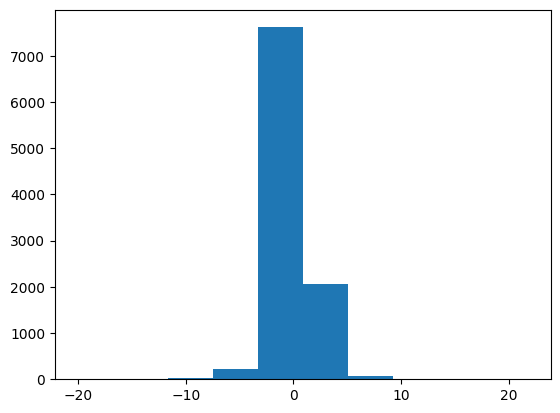

Mean: -0.040793216878827636
Variance: 2.8212487301953026


In [ ]:
data1 = fsst.dist(mu=0, sigma=1, nu= 3, alpha=1)
hasilrandom1 = pm.draw(data1, draws=10000)
plt.hist(hasilrandom1)
plt.show()
print(f"Mean: {np.mean(hasilrandom1)}")
print(f"Variance: {np.var(hasilrandom1)}")

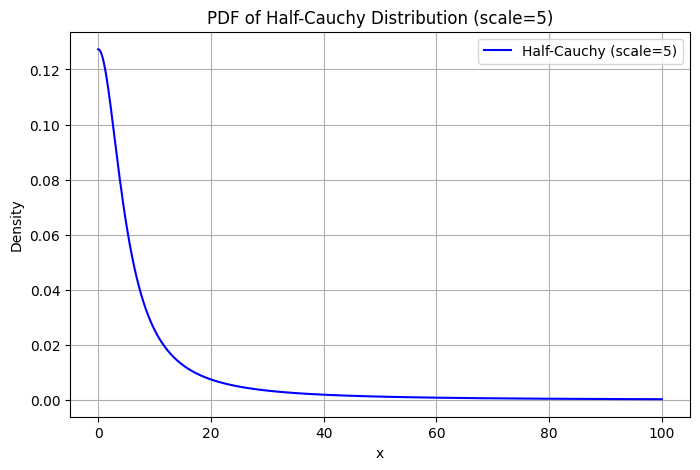

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import halfcauchy

# Parameter scale
scale = 5

# Buat range x
x = np.linspace(0, 100, 500)  # mulai dari 0 (karena half-cauchy) sampai 30

# Hitung pdf
pdf = halfcauchy(scale=scale).pdf(x)

# Plot
plt.figure(figsize=(8,5))
plt.plot(x, pdf, label='Half-Cauchy (scale=5)', color='blue')
plt.title('PDF of Half-Cauchy Distribution (scale=5)')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
with pm.Model() as model1:
    mu = pm.Normal('mu', 0, 5)
    sigma = pm.HalfCauchy('sigma', 5)
    alpha = pm.Gamma('alpha', 2, 1.5)
    nu = pm.Gamma('nu', 2, 15)
    fsst(
        'FSST',
        mu, sigma, nu, alpha,
        hasilrandom1
    )
with model1:
    trace_validasi1 = pm.sample(**sampler_kwargs)

Output()

In [ ]:
az.summary(trace_validasi1, round_to=3, hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha  0.977  0.013     0.954      1.003      0.000    0.000  2206.736   
mu     0.010  0.022    -0.035      0.052      0.000    0.000  2229.413   
nu     2.829  0.090     2.650      3.005      0.002    0.001  2573.350   
sigma  0.986  0.013     0.961      1.011      0.000    0.000  2642.812   

       ess_tail  r_hat  
alpha  2538.022  1.001  
mu     2376.122  1.001  
nu     2627.564  1.002  
sigma  2855.916  1.001

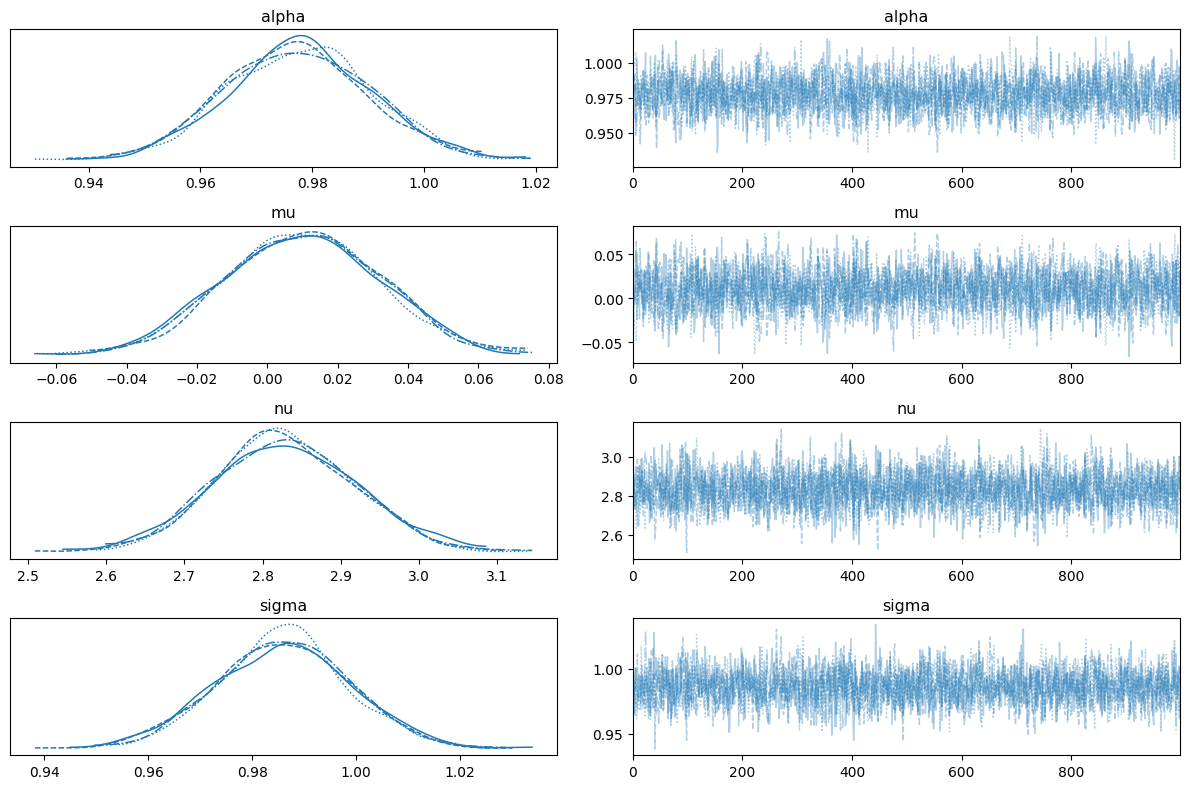

In [ ]:
az.plot_trace(trace_validasi1)
plt.tight_layout()
plt.show()

In [ ]:
summary = az.summary(trace_validasi1, round_to=3)
mean_values = summary['mean']
print(mean_values)

alpha    0.977
mu       0.010
nu       2.829
sigma    0.986
Name: mean, dtype: float64


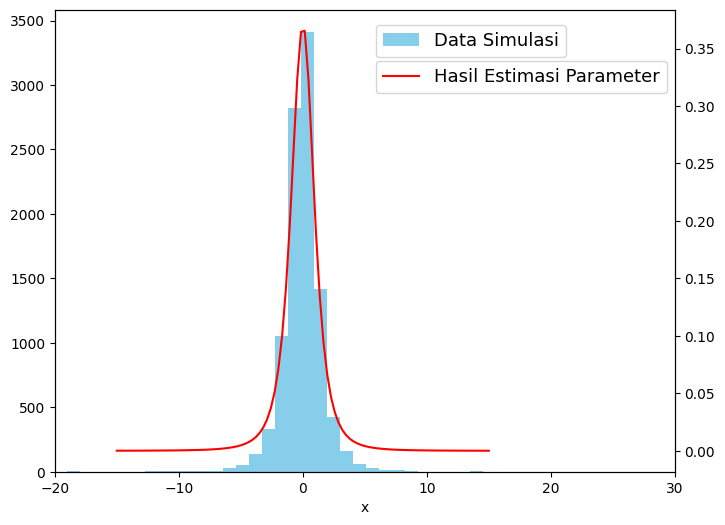

In [ ]:
x = np.linspace(-15,15, 100)
y = [math.exp(rv_logp_fn(value=x,
                          mu=mean_values.iloc[1],
                          sigma=mean_values.iloc[3],
                          nu=mean_values.iloc[2],
                          alpha=mean_values.iloc[0])) for x in x]

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(hasilrandom1,bins=40, label='Data Simulasi', color='skyblue')
ax.set_xlabel("x")
legend = plt.legend(fontsize=13)
legend.set_bbox_to_anchor((0.775, 0.87), transform=plt.gcf().transFigure)

ax2 = ax.twinx()
ax2.plot(x, y, label='Hasil Estimasi Parameter', color='red', linewidth=1.5)
legend = plt.legend(fontsize=13)
legend.set_bbox_to_anchor((0.515, 0.81), transform=plt.gcf().transFigure)
plt.xlim(-20, 30)
plt.show()

###(0, 1, 3, 0.6)

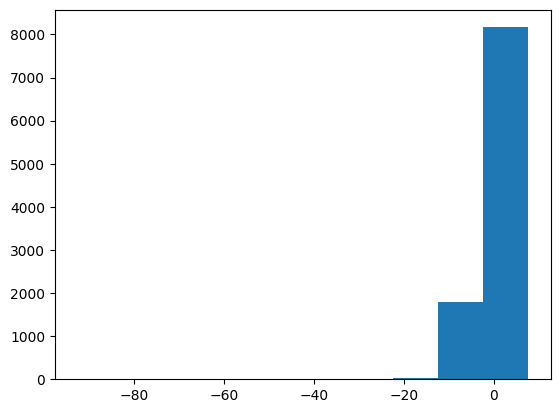

Mean: -1.1705031891338304
Variance: 5.684836350970388


In [ ]:
data2 = fsst.dist(mu=0, sigma=1, nu= 3, alpha=0.6)
hasilrandom2 = pm.draw(data2, draws=10000)
plt.hist(hasilrandom2)
plt.show()
print(f"Mean: {np.mean(hasilrandom2)}")
print(f"Variance: {np.var(hasilrandom2)}")

In [ ]:
with pm.Model() as model1:
    mu = pm.Normal('mu', 0, 5)
    sigma = pm.HalfCauchy('sigma', 5)
    alpha = pm.Gamma('alpha', 2, 1.5)
    nu = pm.Gamma('nu', 2, 15)
    fsst(
        'FSST',
        mu, sigma, nu, alpha,
        hasilrandom2
    )
with model1:
    trace_validasi2 = pm.sample(**sampler_kwargs)

Output()

In [ ]:
az.summary(trace_validasi2, round_to=3, hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha  0.586  0.009     0.568      0.602      0.000    0.000  1803.986   
mu     0.057  0.022     0.016      0.103      0.001    0.000  1841.526   
nu     2.844  0.091     2.672      3.018      0.002    0.001  2616.753   
sigma  0.972  0.015     0.943      1.001      0.000    0.000  2093.394   

       ess_tail  r_hat  
alpha  2265.970  1.005  
mu     2291.684  1.005  
nu     2468.618  1.001  
sigma  2183.845  1.002

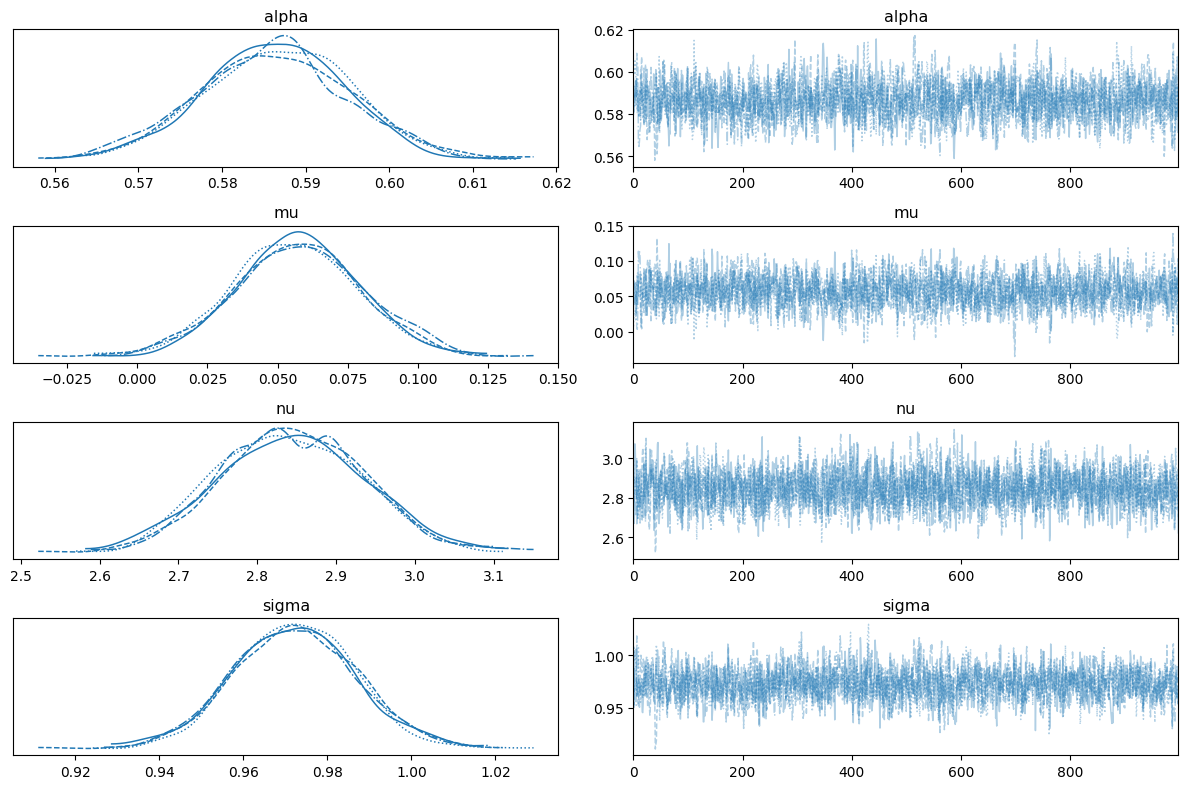

In [ ]:
az.plot_trace(trace_validasi2)
plt.tight_layout()
plt.show()

alpha    0.586
mu       0.057
nu       2.844
sigma    0.972
Name: mean, dtype: float64


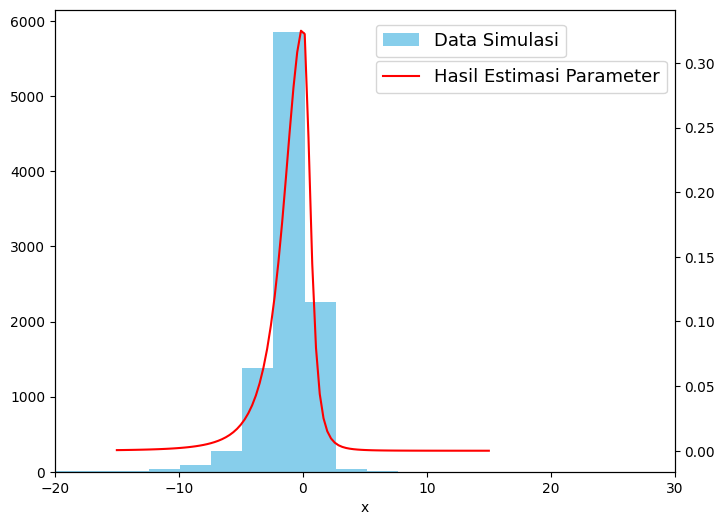

In [ ]:
summary = az.summary(trace_validasi2, round_to=3)
mean_values = summary['mean']
print(mean_values)
x = np.linspace(-15,15, 100)
y = [math.exp(rv_logp_fn(value=x,
                          mu=mean_values.iloc[1],
                          sigma=mean_values.iloc[3],
                          nu=mean_values.iloc[2],
                          alpha=mean_values.iloc[0])) for x in x]

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(hasilrandom2,bins=40, label='Data Simulasi', color='skyblue')
ax.set_xlabel("x")
legend = plt.legend(fontsize=13)
legend.set_bbox_to_anchor((0.775, 0.87), transform=plt.gcf().transFigure)

ax2 = ax.twinx()
ax2.plot(x, y, label='Hasil Estimasi Parameter', color='red', linewidth=1.5)
legend = plt.legend(fontsize=13)
legend.set_bbox_to_anchor((0.515, 0.81), transform=plt.gcf().transFigure)
plt.xlim(-20, 30)
plt.show()

###(0, 1, 3, 2)

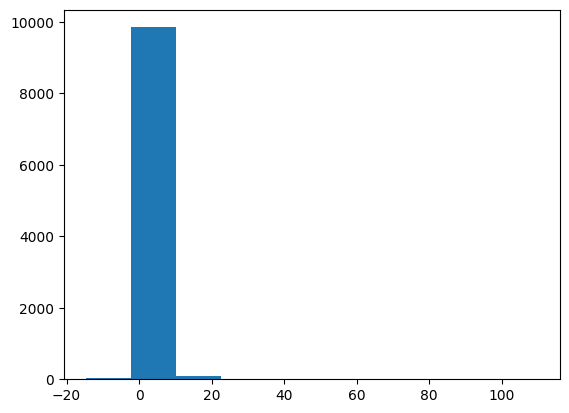

Mean: 1.6378828907739988
Variance: 7.295577692204165


In [ ]:
data3 = fsst.dist(mu=0, sigma=1, nu= 3, alpha=2)
hasilrandom3 = pm.draw(data3, draws=10000)
plt.hist(hasilrandom3)
plt.show()
print(f"Mean: {np.mean(hasilrandom3)}")
print(f"Variance: {np.var(hasilrandom3)}")

In [ ]:
with pm.Model() as model1:
    mu = pm.Normal('mu', 0, 5)
    sigma = pm.HalfCauchy('sigma', 5)
    alpha = pm.Gamma('alpha', 2, 1.5)
    nu = pm.Gamma('nu', 2, 15)
    fsst(
        'FSST',
        mu, sigma, nu, alpha,
        hasilrandom3
    )
with model1:
    trace_validasi3 = pm.sample(**sampler_kwargs)

Output()

In [ ]:
az.summary(trace_validasi3, round_to=3, hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha  2.039  0.035     1.974      2.108      0.001    0.001  1639.240   
mu    -0.028  0.023    -0.073      0.014      0.001    0.000  1657.724   
nu     2.915  0.094     2.735      3.101      0.002    0.002  2269.810   
sigma  0.969  0.016     0.937      0.999      0.000    0.000  1645.924   

       ess_tail  r_hat  
alpha  2048.312  1.000  
mu     2048.995  1.001  
nu     2397.077  1.000  
sigma  1961.242  1.002

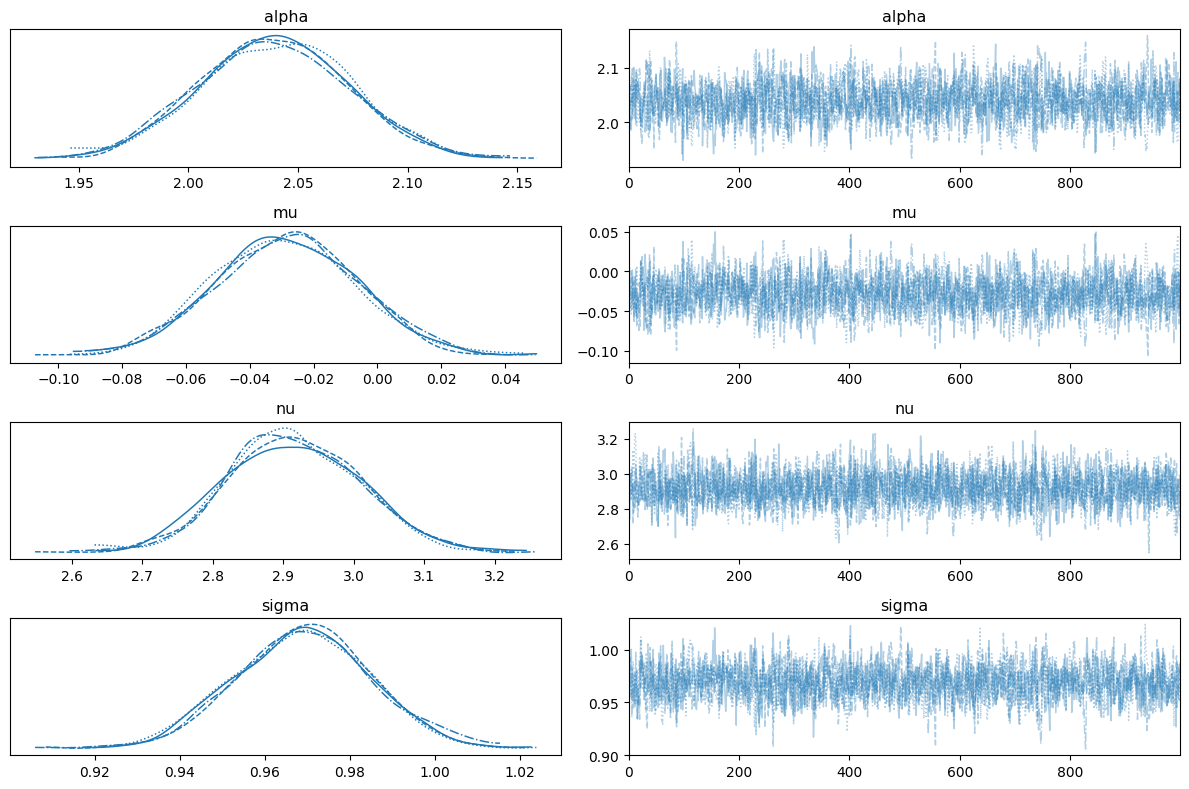

In [ ]:
az.plot_trace(trace_validasi3)
plt.tight_layout()
plt.show()

alpha    2.039
mu      -0.028
nu       2.915
sigma    0.969
Name: mean, dtype: float64


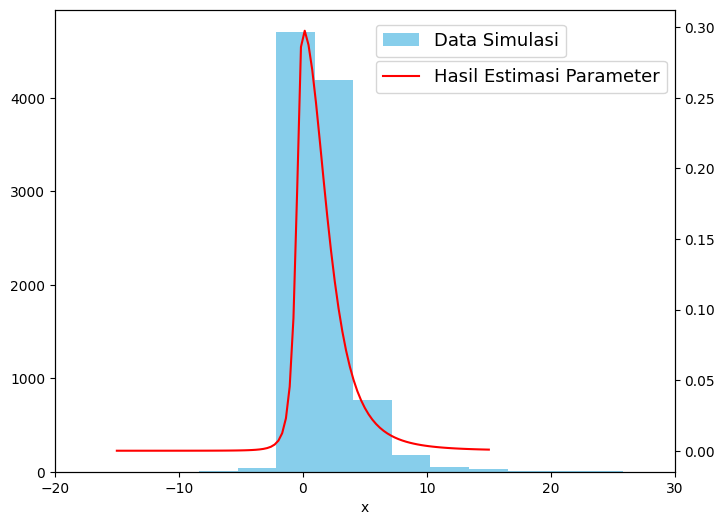

In [ ]:
summary = az.summary(trace_validasi3, round_to=3)
mean_values = summary['mean']
print(mean_values)
x = np.linspace(-15,15, 100)
y = [math.exp(rv_logp_fn(value=x,
                          mu=mean_values.iloc[1],
                          sigma=mean_values.iloc[3],
                          nu=mean_values.iloc[2],
                          alpha=mean_values.iloc[0])) for x in x]

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(hasilrandom3,bins=40, label='Data Simulasi', color='skyblue')
ax.set_xlabel("x")
legend = plt.legend(fontsize=13)
legend.set_bbox_to_anchor((0.775, 0.87), transform=plt.gcf().transFigure)

ax2 = ax.twinx()
ax2.plot(x, y, label='Hasil Estimasi Parameter', color='red', linewidth=1.5)
legend = plt.legend(fontsize=13)
legend.set_bbox_to_anchor((0.515, 0.81), transform=plt.gcf().transFigure)
plt.xlim(-20, 30)
plt.show()

##Simulasi Regresi

In [ ]:
# data untuk uji coba regresi
np.random.seed(42)
x1 = np.random.normal(0, 1, 20000)

# parameter
b0_true = 0.15
b1_true = 0.36
ycap = b0_true + b1_true * x1

# error
eps = pm.draw(fsst.dist(0, 1, 3, 2), draws=20000, random_seed=42)
eps1 = pm.draw(fsst.dist(0, 1, 3, 0.6), draws=20000, random_seed=42)
eps2 = pm.draw(fsst.dist(0, 1, 3, 1), draws=20000, random_seed=42)
eps3 = np.random.normal(0, 1, 20000)

# y
y = ycap + eps
y1 = ycap + eps1
y2 = ycap + eps2
y3 = ycap + eps3

# konversi ke data frame
dataCobaRegresi = pd.DataFrame({'x1': x1, 'y': y, 'y1': y1, 'y2': y2, 'y3': y3})

In [ ]:
priors = {
    # "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    # "x1": bmb.Prior("Normal", mu=0, sigma=5),
    # "sigma": bmb.Prior("HalfCauchy", beta=5),
    "sigma": bmb.Prior("Exponential", lam=1),
    "nu": bmb.Prior("Gamma", alpha=2, beta=15),
    "alpha": bmb.Prior("Gamma", alpha=2, beta=1.5)
}
modelCobaRegresi = bmb.Model("y ~ x1",
                             dataCobaRegresi,
                             family=fsst_family,
                             priors=priors
                             )
paramsCobaRegresi = modelCobaRegresi.fit(**sampler_kwargs)

Output()

In [ ]:
with pm.Model() as regresifsst:
    b0 = pm.Normal('b0',0, 5)
    b1 = pm.Normal('b1',0, 1)
    sigma = pm.HalfCauchy('sigma',5)
    nu = pm.Gamma('nu',2,15)
    alpha = pm.Gamma('alpha',2,1.5)

    eps = b0 + b1*x1

    fsst('Regresi FSST',
         mu=eps, sigma=sigma, alpha=alpha,
         observed=y)
    step = pm.NUTS(target_accept=0.95, max_treedepth=15)
    trace2 = pm.sample(**sampler_kwargs)

az.plot_trace(trace2)

In [ ]:
modelCobaRegresi

       Formula: y ~ x1
        Family: fsst
          Link: mu = identity
  Observations: 20000
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
            x1 ~ Normal(mu: 0.0, sigma: 2.4945)
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)
            nu ~ Gamma(alpha: 2.0, beta: 15.0)
            alpha ~ Gamma(alpha: 2.0, beta: 1.5)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'nu'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'x1'}>, <Axes: >]], dtype=object)

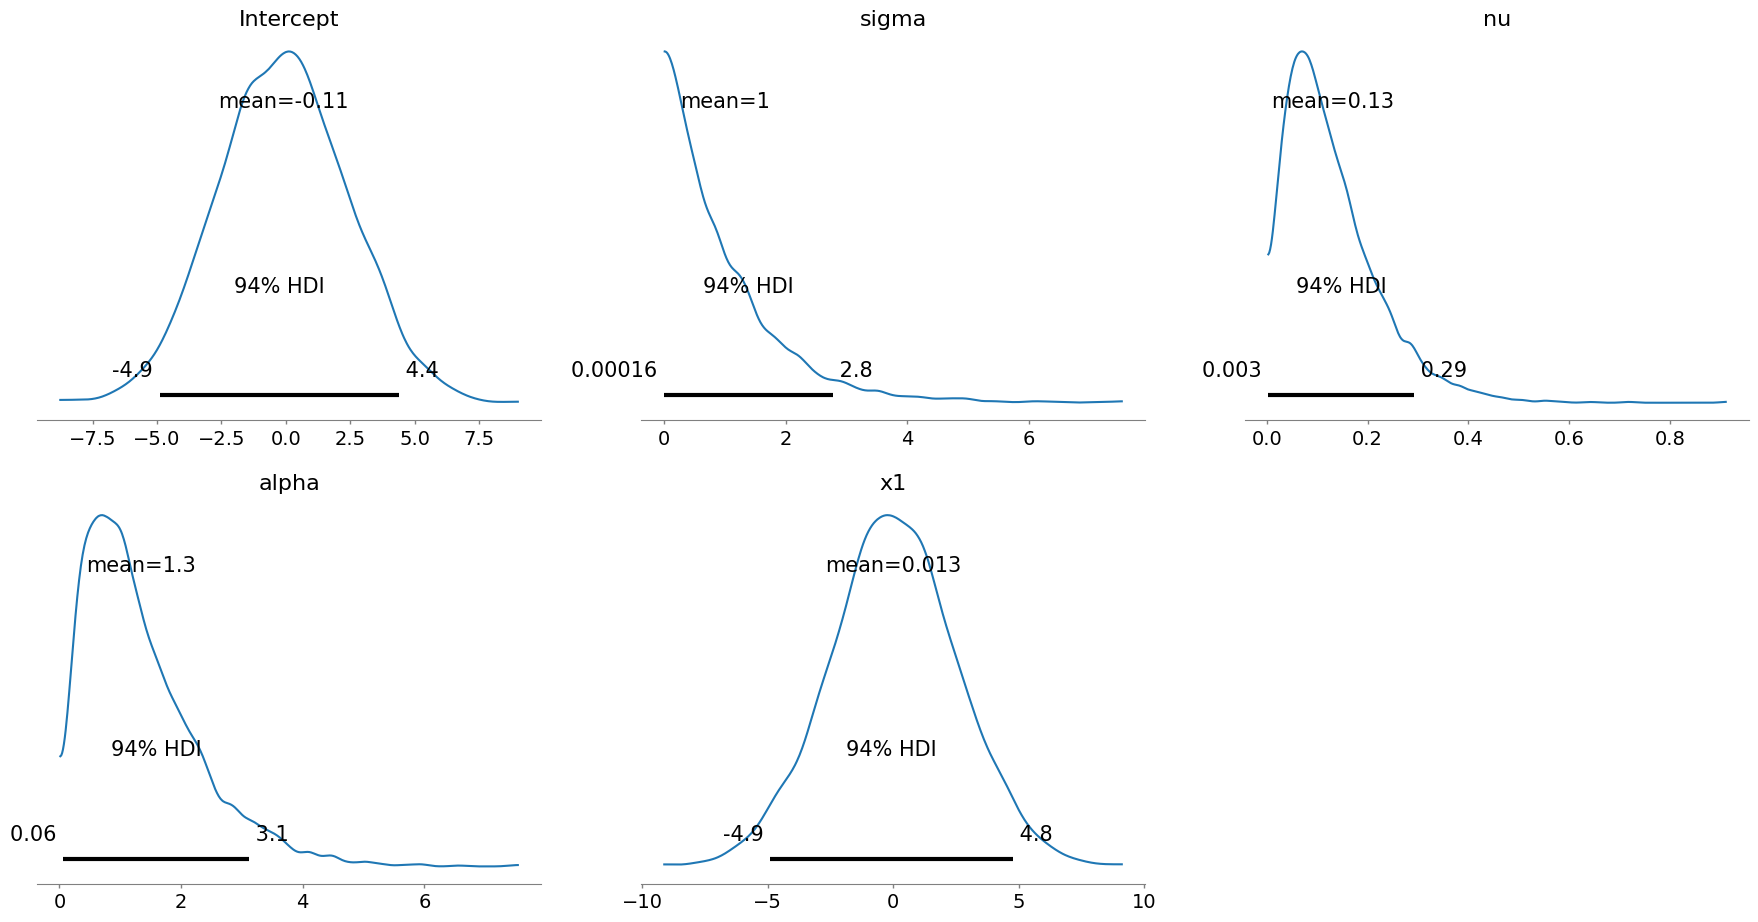

In [ ]:
modelCobaRegresi.plot_priors()

In [ ]:
az.summary(paramsCobaRegresi, hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  0.174  0.016     0.143      0.205      0.000    0.000    2175.0   
alpha      1.961  0.022     1.918      2.005      0.000    0.000    2153.0   
nu         2.829  0.065     2.696      2.949      0.001    0.001    3471.0   
sigma      0.993  0.012     0.971      1.015      0.000    0.000    2376.0   
x1         0.347  0.008     0.331      0.364      0.000    0.000    4000.0   

           ess_tail  r_hat  
Intercept    2942.0    1.0  
alpha        2459.0    1.0  
nu           2694.0    1.0  
sigma        2691.0    1.0  
x1           2591.0    1.0

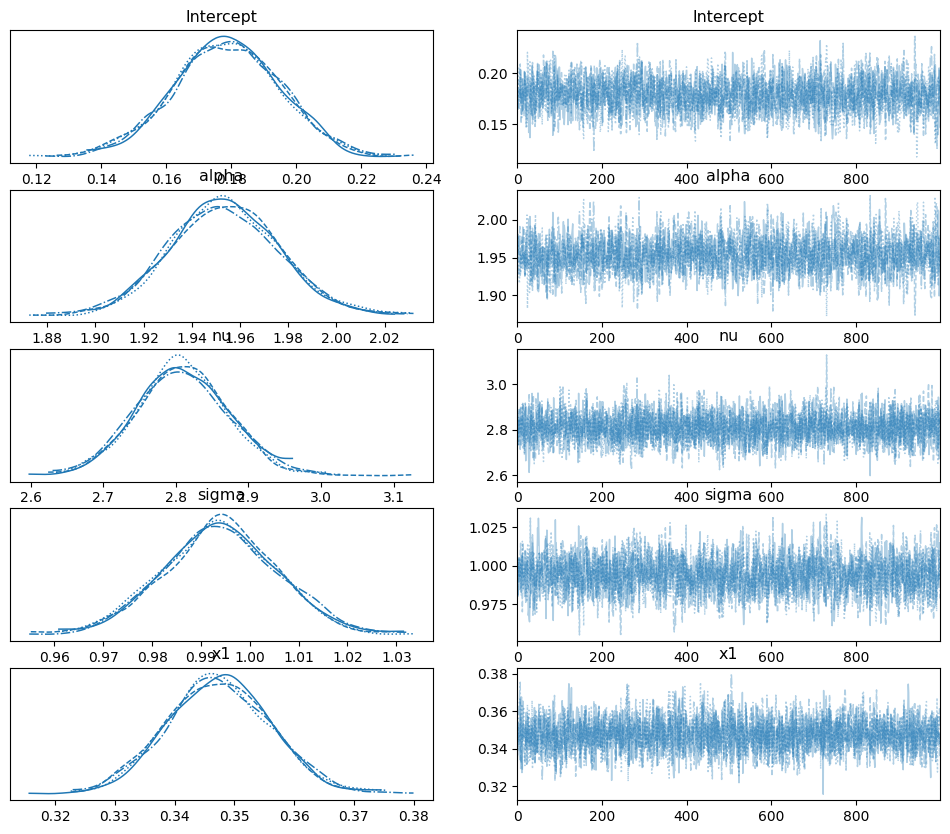

In [ ]:
az.plot_trace(paramsCobaRegresi)
plt.show()

In [ ]:
priors = {
    # "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    # "x1": bmb.Prior("Normal", mu=0, sigma=5),
    "sigma": bmb.Prior("HalfCauchy", beta=5),
    # "sigma": bmb.Prior("Exponential", lam=1),
    "nu": bmb.Prior("Gamma", alpha=2, beta=15),
    "alpha": bmb.Prior("Gamma", alpha=2, beta=1.5)
}
modelCobaRegresi = bmb.Model("y ~ x1",
                             dataCobaRegresi,
                             family=fsst_family,
                             priors=priors
                             )
paramsCobaRegresi = modelCobaRegresi.fit(**sampler_kwargs)

Output()

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'nu'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'x1'}>, <Axes: >]], dtype=object)

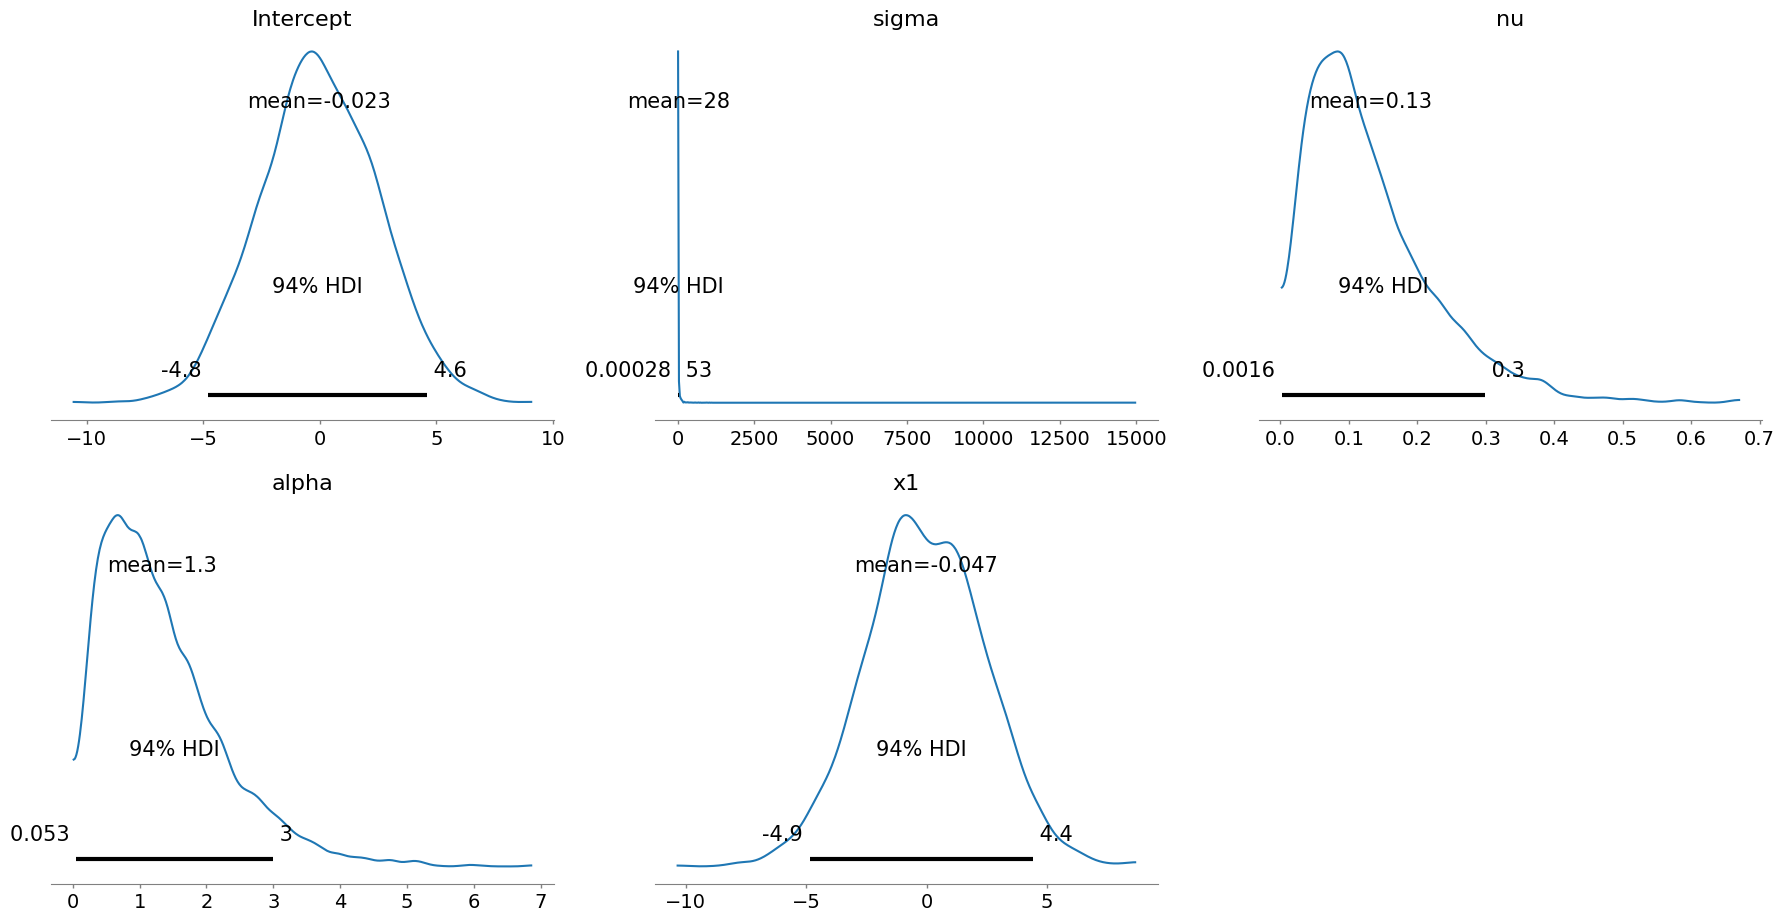

In [ ]:
modelCobaRegresi.plot_priors()

In [ ]:
az.summary(paramsCobaRegresi, hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  0.174  0.016     0.144      0.205      0.000    0.000    1843.0   
alpha      1.961  0.022     1.917      2.004      0.001    0.000    1819.0   
nu         2.829  0.063     2.707      2.951      0.001    0.001    3224.0   
sigma      0.993  0.012     0.970      1.016      0.000    0.000    2024.0   
x1         0.347  0.009     0.331      0.365      0.000    0.000    3811.0   

           ess_tail  r_hat  
Intercept    2429.0    1.0  
alpha        2548.0    1.0  
nu           2971.0    1.0  
sigma        2423.0    1.0  
x1           2874.0    1.0

In [ ]:
modelCobaRegresi = bmb.Model("y1 ~ x1", dataCobaRegresi, family=fsst_family, priors=priors)
paramsCobaRegresi = modelCobaRegresi.fit(**sampler_kwargs)
az.summary(paramsCobaRegresi, hdi_prob=0.95)

Output()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  0.143  0.016     0.112      0.175      0.000    0.000    2501.0   
alpha      0.600  0.006     0.588      0.613      0.000    0.000    2424.0   
nu         2.840  0.063     2.711      2.956      0.001    0.001    3614.0   
sigma      0.989  0.010     0.970      1.010      0.000    0.000    2508.0   
x1         0.358  0.008     0.341      0.373      0.000    0.000    3739.0   

           ess_tail  r_hat  
Intercept    2713.0    1.0  
alpha        2534.0    1.0  
nu           2902.0    1.0  
sigma        2683.0    1.0  
x1           3126.0    1.0

In [ ]:
modelCobaRegresi

       Formula: y1 ~ x1
        Family: fsst
          Link: mu = identity
  Observations: 20000
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            x1 ~ Normal(mu: 0.0, sigma: 5.0)
        
        Auxiliary parameters
            alpha ~ Gamma(alpha: 2.0, beta: 1.5)
            sigma ~ HalfCauchy(beta: 5.0)
            nu ~ Gamma(alpha: 2.0, beta: 15.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

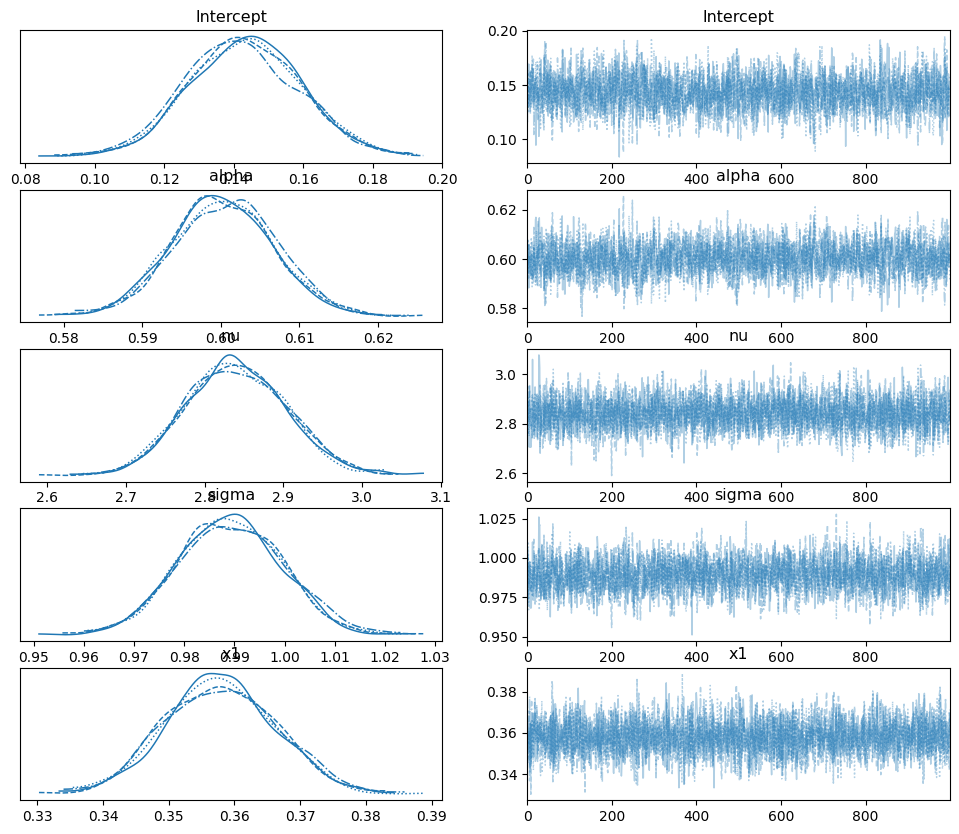

In [ ]:
az.plot_trace(paramsCobaRegresi)
plt.show()

In [ ]:
modelCobaRegresi = bmb.Model("y2 ~ x1", dataCobaRegresi, family=fsst_family, priors=priors)
paramsCobaRegresi = modelCobaRegresi.fit(**sampler_kwargs)
az.summary(paramsCobaRegresi, hdi_prob=0.95)

Output()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  0.144  0.016     0.112      0.174      0.000    0.000    3044.0   
alpha      0.999  0.009     0.980      1.017      0.000    0.000    3011.0   
nu         2.823  0.062     2.705      2.950      0.001    0.001    3549.0   
sigma      0.984  0.009     0.967      1.002      0.000    0.000    3693.0   
x1         0.353  0.008     0.336      0.369      0.000    0.000    3564.0   

           ess_tail  r_hat  
Intercept    2658.0    1.0  
alpha        2814.0    1.0  
nu           2845.0    1.0  
sigma        3046.0    1.0  
x1           2643.0    1.0

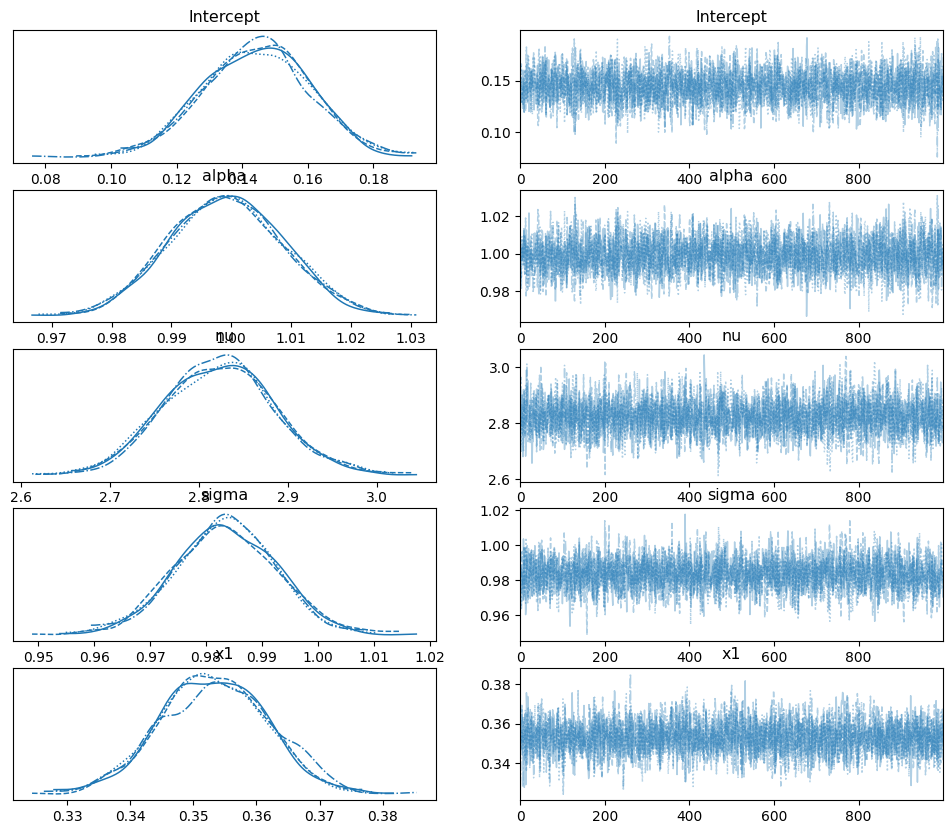

In [ ]:
az.plot_trace(paramsCobaRegresi)
plt.show()

In [ ]:
modelCobaRegresi = bmb.Model("y3 ~ x1", dataCobaRegresi, family=fsst_family, priors=priors)
paramsCobaRegresi = modelCobaRegresi.fit(**sampler_kwargs)
az.summary(paramsCobaRegresi, hdi_prob=0.95)

Output()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
Intercept   0.136  0.019     0.099      0.172       0.00     0.00    2000.0   
alpha       1.002  0.012     0.980      1.026       0.00     0.00    2003.0   
nu         11.486  0.530    10.532     12.590       0.01     0.01    2785.0   
sigma       0.926  0.006     0.915      0.937       0.00     0.00    3159.0   
x1          0.378  0.007     0.365      0.392       0.00     0.00    3564.0   

           ess_tail  r_hat  
Intercept    2337.0    1.0  
alpha        2283.0    1.0  
nu           2279.0    1.0  
sigma        2625.0    1.0  
x1           2617.0    1.0

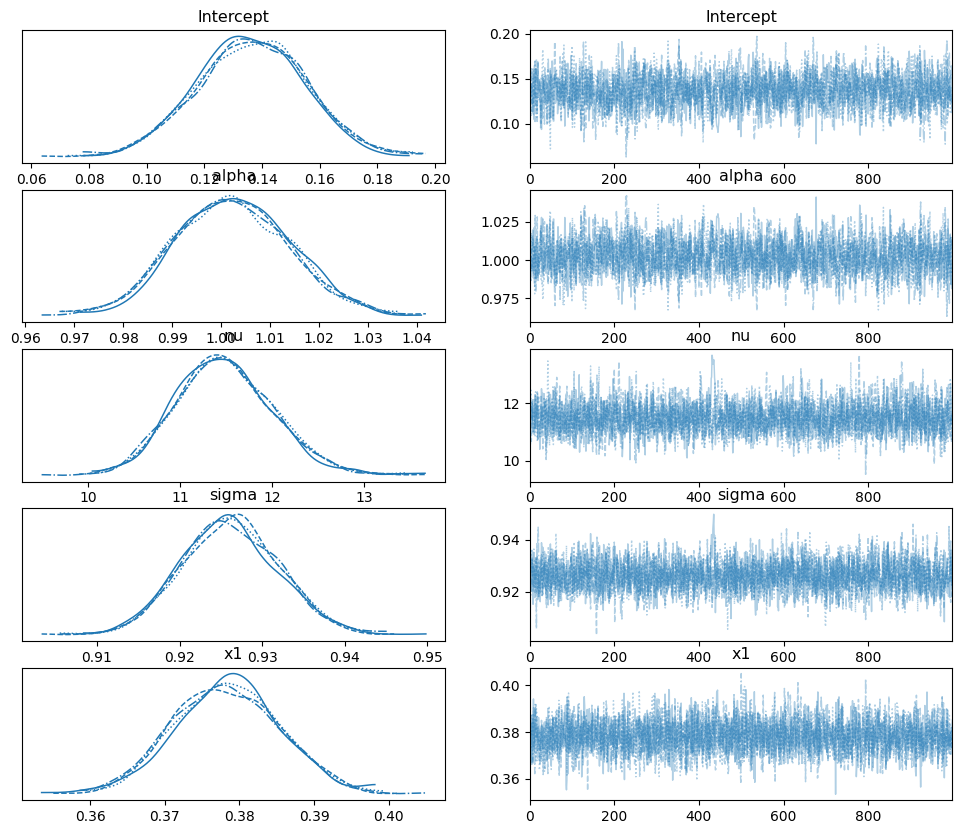

In [ ]:
az.plot_trace(paramsCobaRegresi)
plt.show()

# IMPLEMENTASI

## Kemiskinan


In [ ]:
import pandas as pd

df = pd.read_excel("data kemiskinan.xlsx")
data = df.iloc[:, 1]

###Ringkasan data

In [ ]:
import pandas as pd
from scipy import stats

summary = {
    'Minimum': data.min(),
    'Maksimum': data.max(),
    'Mean': data.mean(),
    'Median': data.median(),
    'Modus': data.mode().iloc[0] if not data.mode().empty else None,
    'Standar Deviasi': data.std(),
    'Skewness': stats.skew(data),
    'Kurtosis': stats.kurtosis(data)
}

summary_df = pd.DataFrame(summary, index=['Nilai']).T
summary_df.columns = ['Statistik']

# Tampilkan tabel
print(summary_df)

                 Statistik
Minimum           1.680000
Maksimum         43.650000
Mean             11.972607
Median            9.695000
Modus             7.470000
Standar Deviasi   7.754665
Skewness          1.562236
Kurtosis          2.534934


### Histogram dan Boxplot


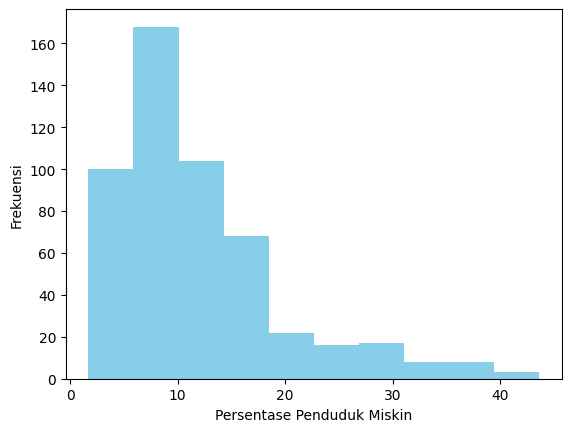

In [ ]:
import matplotlib.pyplot as plt

plt.hist(data, color='skyblue')
plt.xlabel("Persentase Penduduk Miskin")
plt.ylabel("Frekuensi")
# plt.title("Histogram Persentase Penduduk Miskin Tahun 2019")
plt.show()

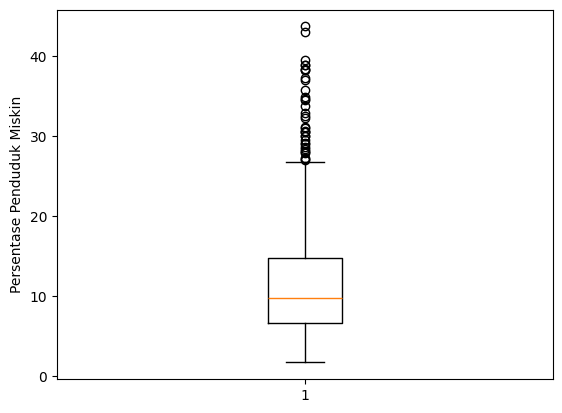

In [ ]:
# Membuat boxplot
plt.boxplot(data)

# Menambahkan label dan judul
plt.ylabel("Persentase Penduduk Miskin")
# plt.title("Boxplot Persentase Penduduk Miskin Tahun 2019")

# Menampilkan plot
plt.show()

### Uji Normalitas dan Kemencengan


In [ ]:
# Normality test (Shapiro-Wilk test)
shapiro_test_result = scipy.stats.shapiro(data)
print(f"Shapiro-Wilk test (p-value): {shapiro_test_result[1]}")

Shapiro-Wilk test (p-value): 4.045197740951576e-21


### Estimasi Parameter

Output()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     11.968  0.329    11.322     12.593      0.005    0.006  4235.143   
sigma   7.764  0.247     7.299      8.243      0.004    0.004  4187.149   

       ess_tail  r_hat  
mu     2712.518  1.002  
sigma  3020.569  1.000

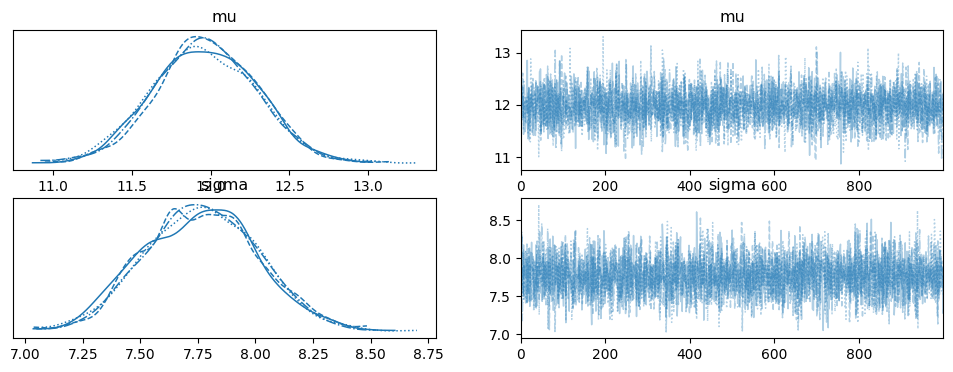

In [ ]:
#Distribusi Normal
with pm.Model() as modelNormal:
    mu = pm.HalfNormal('mu', 100)
    sigma = pm.HalfCauchy('sigma',5)

    pm.Normal('Regresi Normal', mu=mu, sigma=sigma, observed=data)
    traceNormal = pm.sample(**sampler_kwargs, idata_kwargs={"log_likelihood": True})

az.plot_trace(traceNormal)
az.summary(traceNormal, round_to=3, hdi_prob=0.95)

In [ ]:
#Distribusi FSST
with pm.Model() as modelFSST:
    mu = pm.HalfNormal('mu', 100)
    sigma = pm.HalfCauchy('sigma', 5)
    alpha = pm.Gamma('alpha', 2, 1.5) #berdasarkan skewness data
    nu = pm.Gamma('nu', 2, 15)

    fsst(
        'FSST',
        mu, sigma, nu, alpha,
        data
    )
    traceFSST = pm.sample(**sampler_kwargs,idata_kwargs={"log_likelihood": True} )

Output()

In [ ]:
az.summary(traceNormal, round_to=3, hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     11.968  0.329    11.322     12.593      0.005    0.006  4235.143   
sigma   7.764  0.247     7.299      8.243      0.004    0.004  4187.149   

       ess_tail  r_hat  
mu     2712.518  1.002  
sigma  3020.569  1.000

In [ ]:
az.summary(traceFSST, round_to=3, hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha  2.762  0.249     2.299      3.260      0.007    0.004  1460.238   
mu     4.751  0.261     4.259      5.277      0.007    0.004  1573.354   
nu     2.153  0.221     1.742      2.592      0.004    0.004  2535.487   
sigma  2.644  0.227     2.245      3.144      0.006    0.004  1617.150   

       ess_tail  r_hat  
alpha  1946.568  1.003  
mu     2176.424  1.002  
nu     2173.209  1.002  
sigma  2031.437  1.002

### Karakteristik Data

In [ ]:
summary1 = az.summary(traceNormal, round_to=3)
summary2 = az.summary(traceFSST, round_to=3)

mean_values_normal = summary1['mean']
mean_values_fsst = summary2['mean']

print("Parameter Distribusi Normal")
print(mean_values_normal)
print("Parameter Distribusi FSST")
print(mean_values_fsst)

Parameter Distribusi Normal
mu       11.968
sigma     7.764
Name: mean, dtype: float64
Parameter Distribusi FSST
alpha    2.762
mu       4.751
nu       2.153
sigma    2.644
Name: mean, dtype: float64


In [ ]:
from scipy.special import beta
import scipy.stats as st
import numpy as np

# Ambil nilai rata-rata parameter dari hasil ringkasan
mu    = summary2.loc['mu',    'mean']
sigma = summary2.loc['sigma', 'mean']
alpha = summary2.loc['alpha', 'mean']
nu    = summary2.loc['nu',    'mean']

# 1) Mean (τ = ν > 1)
if nu > 1:
    num_mean = 2 * sigma * np.sqrt(nu) * (alpha - 1/alpha)
    den_mean = (nu - 1) * beta(0.5, nu/2)
    mean_st3 = mu + num_mean/den_mean
    print(f"Mean ST3    = {mean_st3:.3f}")
else:
    print("Mean ST3  : ν harus > 1")

# 2) Median
# α1 dan α2 sesuai rumus:
alpha1 = (1 + nu**2) / 4
alpha2 = (3*nu**2 - 1) / (4*nu**2)

if nu <= 1:
    # median = μ + (σ/ν) * t_{α1, ν}
    t_a1 = st.t.ppf(alpha1, df=nu)
    median_st3 = mu + (sigma/nu) * t_a1
else:
    # median = μ + (σ * ν) * t_{α2, ν}
    t_a2 = st.t.ppf(alpha2, df=nu)
    median_st3 = mu + (sigma*nu) * t_a2

print(f"Median ST3  = {median_st3:.3f}")

# 3) Variance (τ = ν > 2)
if nu > 2:
    # 3a) E[Z] digunakan pada mean‐centered Var(Z)
    E_Z = (2 * np.sqrt(nu) * (alpha - 1/alpha)) / ((nu - 1) * beta(0.5, nu/2))
    # 3b) Var(Z)
    var_Z = (nu/(nu-2))*(nu**2 + nu**-2 - 1) - E_Z**2
    variance_st3 = sigma**2 * var_Z
    print(f"Variance ST3= {variance_st3:.3f}")
else:
    print("Variance ST3 : ν harus > 2")

# 4) Skewness (τ = ν > 3)
if nu > 3:
    skewness = (2 * alpha * nu) / ((nu - 3) * np.sqrt(nu)) - (2 / np.sqrt(nu - 1))
    print(f"Skewness ST3 = {skewness:.3f}")
else:
    print("Skewness ST3 : ν harus > 3")


Mean ST3    = 13.198
Median ST3  = 8.144
Variance ST3= 307.500
Skewness ST3 : ν harus > 3


In [ ]:
# Skewness hanya terdefinisi jika nu > 3
if nu > 3:
    # 1) Hitung mu'_3Z (E(Z^3)) sesuai rumus (12)
    mu3Z = (4 * nu**(3/4) * (alpha**4 - alpha**(-4))
            / ((nu - 1) * (nu - 3)
               * beta(0.5, nu/2)
               * (alpha + alpha**(-1))))

    # 2) Skala ke mu_3Y
    mu3Y = sigma**3 * mu3Z

    # 3) Hitung Var(Y)
    varY = sigma**2 * nu / (nu - 2)

    # 4) Hitung skewness
    skewness = mu3Y / varY**1.5

    print(f"Skewness ST3 = {skewness:.3f}")
else:
    print("nu harus lebih besar dari 3 agar kemencengan terdefinisi.")

nu harus lebih besar dari 3 agar kemencengan terdefinisi.


### Visualisasi


In [ ]:
mu = pt.scalar('mu')
sigma = pt.scalar('sigma')
nu = pt.scalar('nu')
alpha = pt.scalar('alpha')
value = pt.scalar('value')

rv1 = fsst.dist(mu=mu, sigma=sigma, nu=nu, alpha=alpha)
rv_logp = pm.logp(rv1, value)
rv_logp_fn = pm.compile_pymc([value, mu, sigma, nu, alpha], rv_logp)

/usr/local/lib/python3.11/dist-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


<ipython-input-193-ddb4b4c78fde>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = [st.norm.pdf(x_val, mean_values_normal[0], mean_values_normal[1]) for x_val in x]


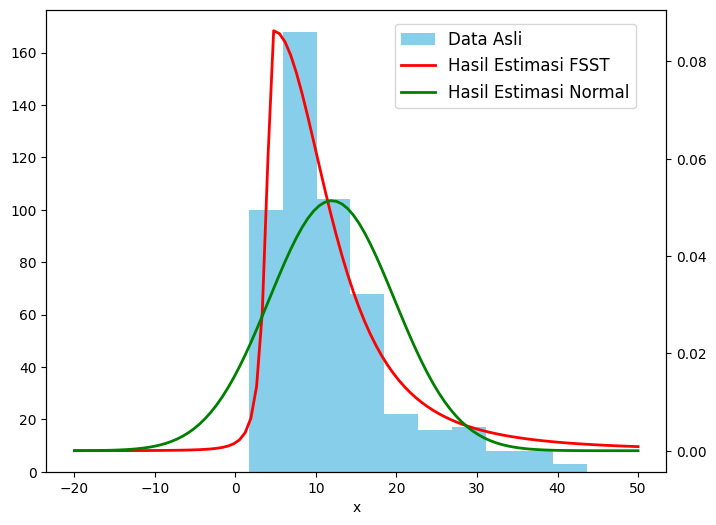

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as st

x = np.linspace(-20, 50, 100)
y = [math.exp(rv_logp_fn(value=x_val,
                         mu=mean_values_fsst.iloc[1],
                         sigma=mean_values_fsst.iloc[3],
                         nu=mean_values_fsst.iloc[2],
                         alpha=mean_values_fsst.iloc[0])) for x_val in x]
y1 = [st.norm.pdf(x_val, mean_values_normal[0], mean_values_normal[1]) for x_val in x]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Histogram
hist_plot = ax.hist(data, label='Data Asli', color='skyblue')
ax.set_xlabel("x")

# Garis PDF
ax2 = ax.twinx()
line1, = ax2.plot(x, y, label='Hasil Estimasi FSST', color='red', linewidth=2)
line2, = ax2.plot(x, y1, label='Hasil Estimasi Normal', color='green', linewidth=2)
y
# Gabungkan legend dari ax dan ax2
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

legend = ax.legend(handles1 + [line1, line2], labels1 + [line1.get_label(), line2.get_label()], fontsize=12)
legend.set_bbox_to_anchor((0.55, 0.87), transform=plt.gcf().transFigure)

plt.show()


## Kriminalitas


In [ ]:
#normal berarti hasil lognya bukan datanya
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.metrics import mean_squared_error

data = pd.read_excel("Data PDRB.xlsx")
data.head()

df = pd.DataFrame(data.iloc[:, 1:])

In [ ]:
x1 = np.log(data["X1"])
y = np.log(data["Y"])

df_log = pd.DataFrame({
    'X1': x1,
    'Y': y
})

In [ ]:
# prior
priors = {
    "Intercept":bmb.Prior("Normal", mu=0, sigma=5),
    "X1": bmb.Prior("Normal", mu=0, sigma=1),
    "sigma": bmb.Prior("HalfCauchy", beta=5),
    "alpha": bmb.Prior("Gamma", alpha=2, beta=0.5),
}

# model regresi dengan bambi
modelBM = bmb.Model("Y ~ X1",  df_log, family=msnburr_family, priors=priors)
modelBM
traceBM = modelBM.fit(**sampler_kwargs, idata_kwargs={"log_likelihood": True})

Output()

In [ ]:
az.summary(traceBM, round_to=5, hdi_prob=0.95)

mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
Intercept  4.44693  1.28973   1.94192    6.94315    0.02123  0.02095   
X1         0.98315  0.08768   0.81210    1.15052    0.00144  0.00143   
alpha      4.17241  2.50071   0.71980    9.35432    0.04143  0.05173   
sigma      0.50578  0.07440   0.38001    0.66638    0.00125  0.00123   

             ess_bulk    ess_tail    r_hat  
Intercept  3749.32277  2803.52380  1.00054  
X1         3775.37074  2662.40458  1.00053  
alpha      3240.67079  2869.83651  1.00004  
sigma      3597.12574  2769.11180  1.00002

### Load Data

In [ ]:
#normal berarti hasil lognya bukan datanya
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.metrics import mean_squared_error

data = pd.read_excel("data kriminal.xlsx")
data.head()

df = pd.DataFrame(data.iloc[:, 1:])

In [ ]:
y = data["jml_kejahatan"]
x1 = data["kepadatan_penduduk"]
x2 = data["jml_penduduk_miskin"]

###Eksplorasi data

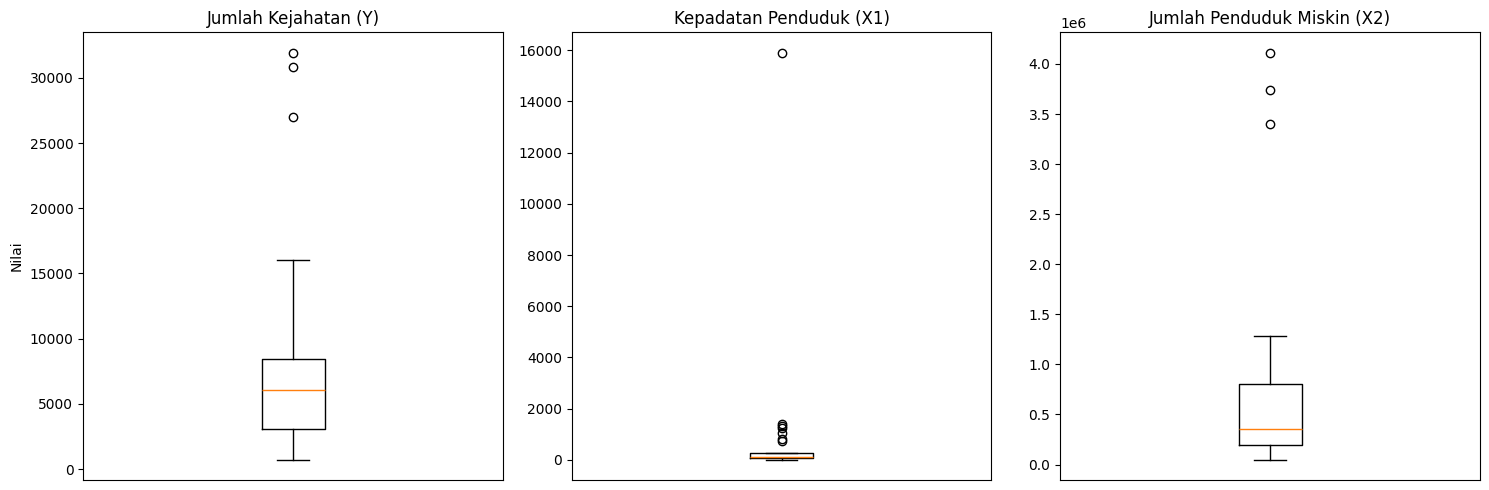

In [ ]:
import matplotlib.pyplot as plt

# Buat figure dan 3 subplot horizontal
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Boxplot 1: y (Jumlah Kejahatan)
axs[0].boxplot(y)
axs[0].set_title("Jumlah Kejahatan (Y)")
axs[0].set_ylabel("Nilai")
axs[0].set_xticks([])

# Boxplot 2: x1 (Kepadatan Penduduk)
axs[1].boxplot(x1)
axs[1].set_title("Kepadatan Penduduk (X1)")
axs[1].set_xticks([])

# Boxplot 3: x2 (Jumlah Penduduk Miskin)
axs[2].boxplot(x2)
axs[2].set_title("Jumlah Penduduk Miskin (X2)")
axs[2].set_xticks([])

# Tampilkan plot
plt.tight_layout()
plt.show()

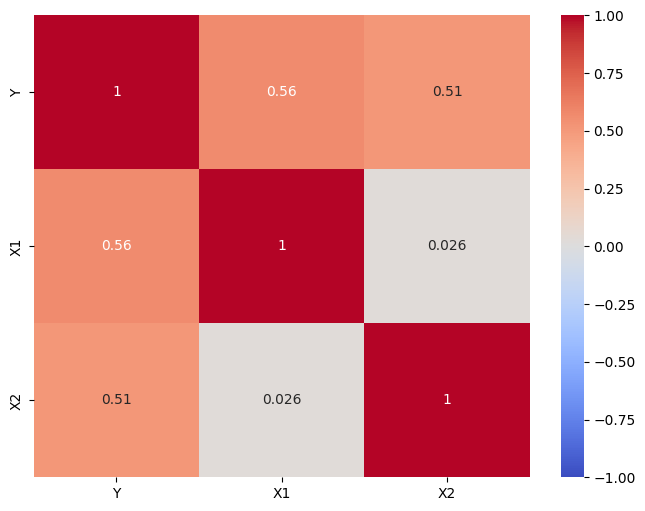

           Y        X1        X2
Y   1.000000  0.564152  0.508440
X1  0.564152  1.000000  0.025822
X2  0.508440  0.025822  1.000000


In [ ]:
# Correlation matrix
correlation_matrix = df.corr()

new_labels = {
    'jml_kejahatan': 'Y',
    'kepadatan_penduduk': 'X1',
    'jml_penduduk_miskin': 'X2'
}

# Rename kolom dan index
correlation_matrix = correlation_matrix.rename(index=new_labels, columns=new_labels)

# Plot heatmap dengan label baru
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

print(correlation_matrix)

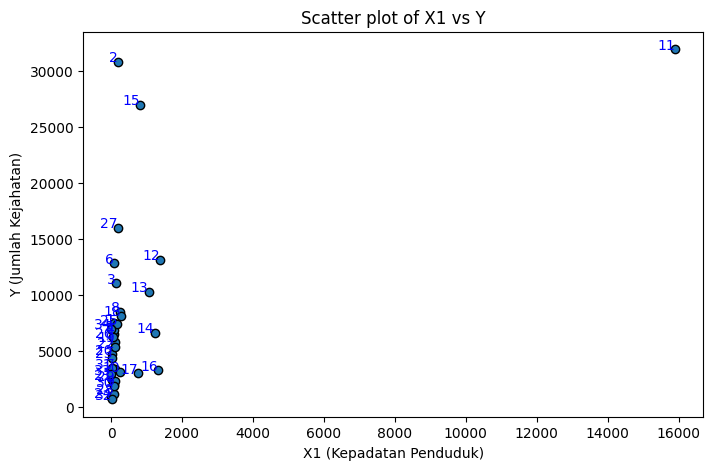

In [ ]:
df = pd.DataFrame(data)

# Scatter plot X1 vs Y
plt.figure(figsize=(8, 5))
plt.scatter(df['kepadatan_penduduk'], df['jml_kejahatan'], edgecolors="black")

# Menambahkan nomor amatan di setiap titik
for i in range(len(df)):
    plt.text(df['kepadatan_penduduk'][i], df['jml_kejahatan'][i], str(i+1),
             fontsize=10, color="blue", ha="right")

# Label
plt.xlabel('X1 (Kepadatan Penduduk)')
plt.ylabel('Y (Jumlah Kejahatan)')
plt.title('Scatter plot of X1 vs Y')
plt.show()

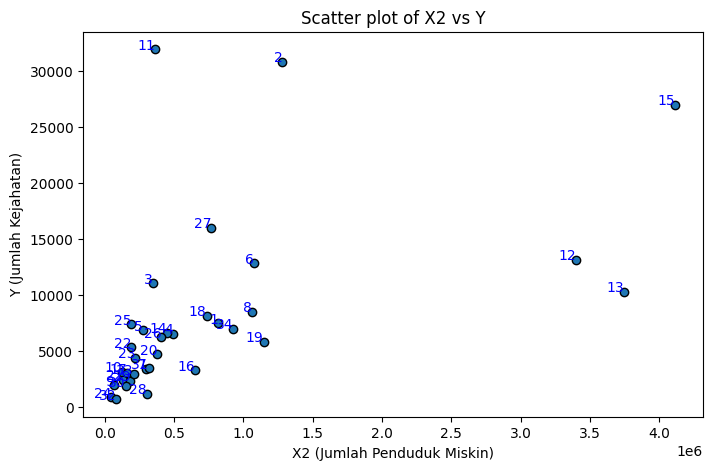

In [ ]:
# Scatter plot X2 vs Y
plt.figure(figsize=(8, 5))
plt.scatter(df['jml_penduduk_miskin'], df['jml_kejahatan'], edgecolors="black")

# Menambahkan nomor amatan di setiap titik
for i in range(len(df)):
    plt.text(df['jml_penduduk_miskin'][i], df['jml_kejahatan'][i], str(i+1),
             fontsize=10, color="blue", ha="right")


# Label
plt.xlabel('X2 (Jumlah Penduduk Miskin)')
plt.ylabel('Y (Jumlah Kejahatan)')
plt.title('Scatter plot of X2 vs Y')
plt.show()

### Cek dengan OLS


In [ ]:
# 1. Mengimpor Pustaka
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.metrics import mean_squared_error

# 2. Menyiapkan Data
X1 = data["kepadatan_penduduk"]
X2 = data["jml_penduduk_miskin"]
Y = data["jml_kejahatan"]
X = pd.concat([X1, X2], axis=1)

# 3. Menambahkan Kolom Konstan
X = sm.add_constant(X)

# 4. Membuat Model Regresi OLS dan Melakukan Fitting
model = sm.OLS(Y, X).fit()

# 5. Melihat Ringkasan Hasil Regresi
print(model.summary())

# 6. Menghitung Residual
residuals = model.resid

y_pred = model.predict(X)
# 7. Menghitung Mean Squared Error (MSE)
mse = mean_squared_error(Y, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

                            OLS Regression Results                            
Dep. Variable:          jml_kejahatan   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     19.92
Date:                Thu, 15 May 2025   Prob (F-statistic):           2.74e-06
Time:                        13:42:00   Log-Likelihood:                -338.76
No. Observations:                  34   AIC:                             683.5
Df Residuals:                      31   BIC:                             688.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3886.2251   1

In [ ]:
import numpy as np

# Hitung Residual Standard Error (RSE)
n = model.nobs  # Jumlah observasi
p = model.df_model + 1  # Jumlah parameter (termasuk intercept)
MSE = np.sum(residuals**2) / (n - p)
RSE = np.sqrt(MSE)

print("Residual Standard Error (RSE):", RSE)


Residual Standard Error (RSE): 5381.839222522416


### Uji Normalitas

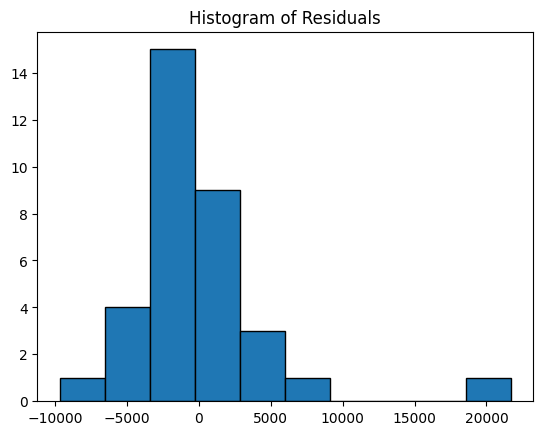

In [ ]:
plt.hist(residuals, edgecolor='black')  # Customize bins, color, and transparency
plt.title('Histogram of Residuals')
plt.show()

In [ ]:
import scipy.stats as stats
# Skewness test

skewness = stats.skew(residuals)
print(f"Skewness: {skewness}")

shapiro_test_result = stats.shapiro(residuals)
print(f"Shapiro-Wilk test (p-value): {shapiro_test_result[1]}")

Skewness: 2.1457828719710963
Shapiro-Wilk test (p-value): 3.304911907553209e-05


### Uji Linearitas

In [ ]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector
import rpy2.robjects.numpy2ri
import rpy2.rinterface_lib.callbacks
import logging

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

utils = importr('utils')
utils.install_packages('tseries')

# Aktifkan konversi numpy
rpy2.robjects.numpy2ri.activate()

# Impor paket tseries dari R
tseries = importr('tseries')

In [ ]:
# Convert numpy arrays to R vectors
x1_r = FloatVector(x1)
x2_r = FloatVector(x2)
y_r = FloatVector(y)

In [ ]:
# Gabungkan x1, x2, x3 menjadi matriks di R
x_combined_r = ro.r['cbind'](x1_r, x2_r)

# Menjalankan Terasvirta Test untuk x1 dan x2
terasvirta_x1_result = tseries.terasvirta_test(x1_r, y_r, type="F", scale=True)
terasvirta_x2_result = tseries.terasvirta_test(x2_r, y_r, type="F", scale=True)
terasvirta_xcombined_result = tseries.terasvirta_test(x_combined_r, y_r, type="F", scale=True)

# Mendapatkan hasil untuk x1
f_statistic_x1 = terasvirta_x1_result.rx2('statistic')[0]
p_value_x1 = terasvirta_x1_result.rx2('p.value')[0]

# Mendapatkan hasil untuk x2
f_statistic_x2 = terasvirta_x2_result.rx2('statistic')[0]
p_value_x2 = terasvirta_x2_result.rx2('p.value')[0]

# Mendapatkan hasil untuk x_combined
f_statistic_x_combined = terasvirta_xcombined_result.rx2('statistic')[0]
p_value_x_combined = terasvirta_xcombined_result.rx2('p.value')[0]

# Menampilkan hasil
print(f'X1 - F-statistic: {f_statistic_x1}, p-value: {p_value_x1}')
print(f'X2 - F-statistic: {f_statistic_x2}, p-value: {p_value_x2}')
print(f'X combined - F-statistic: {f_statistic_x_combined}, p-value: {p_value_x_combined}')

X1 - F-statistic: 3.297647216920991, p-value: 0.05029642913918153
X2 - F-statistic: 3.022305535296119, p-value: 0.06322198713539118
X combined - F-statistic: 3.3325971636265574, p-value: 0.012009378578912155


###Penanganan non-linearitas

####Hapus outlier

In [ ]:
# Menghapus index tertentu
outlier = [0, 10, 11, 12, 14]
df_cleaned = data.drop(index=outlier).reset_index(drop=True)

# Buat DataFrame baru
df_cleaned = pd.DataFrame(df_cleaned)
print(len(df_cleaned))

29


In [ ]:
x1 = df_cleaned["kepadatan_penduduk"]
x2 = df_cleaned["jml_penduduk_miskin"]
y = df_cleaned["jml_kejahatan"]

# Convert numpy arrays to R vectors
x1_r = FloatVector(x1)
x2_r = FloatVector(x2)
y_r = FloatVector(y)

# Gabungkan x1, x2, x3 menjadi matriks di R
x_combined_r = ro.r['cbind'](x1_r, x2_r)

# Menjalankan Terasvirta Test untuk x1 dan x2
terasvirta_x1_result = tseries.terasvirta_test(x1_r, y_r, type="F", scale=True)
terasvirta_x2_result = tseries.terasvirta_test(x2_r, y_r, type="F", scale=True)
terasvirta_xcombined_result = tseries.terasvirta_test(x_combined_r, y_r, type="F", scale=True)

# Mendapatkan hasil untuk x1
f_statistic_x1 = terasvirta_x1_result.rx2('statistic')[0]
p_value_x1 = terasvirta_x1_result.rx2('p.value')[0]

# Mendapatkan hasil untuk x2
f_statistic_x2 = terasvirta_x2_result.rx2('statistic')[0]
p_value_x2 = terasvirta_x2_result.rx2('p.value')[0]

# Mendapatkan hasil untuk x_combined
f_statistic_x_combined = terasvirta_xcombined_result.rx2('statistic')[0]
p_value_x_combined = terasvirta_xcombined_result.rx2('p.value')[0]

# Menampilkan hasil
print(f'X1 - F-statistic: {f_statistic_x1}, p-value: {p_value_x1}')
print(f'X2 - F-statistic: {f_statistic_x2}, p-value: {p_value_x2}')
print(f'X combined - F-statistic: {f_statistic_x_combined}, p-value: {p_value_x_combined}')

X1 - F-statistic: 3.624629628299944, p-value: 0.04087783228218589
X2 - F-statistic: 6.0237832674418685, p-value: 0.0070860468008628885
X combined - F-statistic: 2.14023242433103, p-value: 0.08618232016697469


#### Transformasi log pada y

In [ ]:
x1 = data["kepadatan_penduduk"]
x2 = data["jml_penduduk_miskin"]
y = np.log(data["jml_kejahatan"])

In [ ]:
# Convert numpy arrays to R vectors
x1_r = FloatVector(x1)
x2_r = FloatVector(x2)
y_r = FloatVector(y)

# Gabungkan x1, x2, x3 menjadi matriks di R
x_combined_r = ro.r['cbind'](x1_r, x2_r)

# Menjalankan Terasvirta Test untuk x1 dan x2
terasvirta_x1_result = tseries.terasvirta_test(x1_r, y_r, type="F", scale=True)
terasvirta_x2_result = tseries.terasvirta_test(x2_r, y_r, type="F", scale=True)
terasvirta_xcombined_result = tseries.terasvirta_test(x_combined_r, y_r, type="F", scale=True)

# Mendapatkan hasil untuk x1
f_statistic_x1 = terasvirta_x1_result.rx2('statistic')[0]
p_value_x1 = terasvirta_x1_result.rx2('p.value')[0]

# Mendapatkan hasil untuk x2
f_statistic_x2 = terasvirta_x2_result.rx2('statistic')[0]
p_value_x2 = terasvirta_x2_result.rx2('p.value')[0]

# Mendapatkan hasil untuk x_combined
f_statistic_x_combined = terasvirta_xcombined_result.rx2('statistic')[0]
p_value_x_combined = terasvirta_xcombined_result.rx2('p.value')[0]

# Menampilkan hasil
print(f'X1 - F-statistic: {f_statistic_x1}, p-value: {p_value_x1}')
print(f'X2 - F-statistic: {f_statistic_x2}, p-value: {p_value_x2}')
print(f'X combined - F-statistic: {f_statistic_x_combined}, p-value: {p_value_x_combined}')

X1 - F-statistic: 3.3189090116234525, p-value: 0.049422813317794745
X2 - F-statistic: 8.245385553507592, p-value: 0.001344817415753985
X combined - F-statistic: 4.207130532752119, p-value: 0.0034473771550005416


####Transformasi log pada x dan y

In [ ]:
x1 = np.log(data["kepadatan_penduduk"])
x2 = np.log(data["jml_penduduk_miskin"])
y = np.log(data["jml_kejahatan"])

df_log = pd.DataFrame({
    'X1': x1,
    'X2': x2,
    'Y': y
})

In [ ]:
df_log

X1         X2          Y
0   4.532599  13.616376   8.920389
1   5.298317  14.063963  10.336276
2   4.867534  12.760590   9.311452
3   4.382027  13.103629   8.790269
4   4.276666  12.522051   8.831712
5   4.521789  13.886658   9.461955
6   4.605170  12.619175   8.146999
7   5.497168  13.877226   9.051813
8   4.510860  11.132836   7.577122
9   5.587249  11.763373   8.058011
10  9.674074  12.809158  10.371427
11  7.239933  15.039039   9.483797
12  6.964136  15.135459   9.241548
13  7.112327  13.013597   8.802372
14  6.722630  15.229481  10.203036
15  7.198931  13.391566   8.097731
16  6.620073  12.006707   8.021913
17  5.609472  13.508931   9.010058
18  4.718499  13.952067   8.676758
19  3.526361  12.843734   8.459776
20  2.890372  11.809988   7.801391
21  4.700480  12.167748   8.589514
22  3.367296  12.301019   8.393216
23  2.302585  10.795076   6.775366
24  5.198497  12.163687   8.912608
25  3.891820  12.924790   8.742734
26  5.241747  13.551285   9.680844
27  4.262680  12.620101   7.100852
28  4.672829  12.133663   7.769379
29  4.406719  11.927681   7.529943
30  3.637586  12.668831   8.159089
31  3.663562  11.345690   6.576470
32  2.197225  12.261980   7.996990
33  2.397895  13.739018   8.852808

In [ ]:
print(df_log["Y"].describe())
print(df_log["X1"].describe())
print(df_log["X2"].describe())

count    34.000000
mean      8.580459
std       0.921288
min       6.576470
25%       8.030937
50%       8.709746
75%       9.041375
max      10.371427
Name: Y, dtype: float64
count    34.000000
mean      4.891091
std       1.608272
min       2.197225
25%       3.984535
50%       4.639000
75%       5.564729
max       9.674074
Name: X1, dtype: float64
count    34.000000
mean     12.902534
std       1.083017
min      10.795076
25%      12.164702
50%      12.784874
75%      13.600103
max      15.229481
Name: X2, dtype: float64


In [ ]:
# Convert numpy arrays to R vectors
x1_r = FloatVector(x1)
x2_r = FloatVector(x2)
y_r = FloatVector(y)

# Gabungkan x1, x2, x3 menjadi matriks di R
x_combined_r = ro.r['cbind'](x1_r, x2_r)

# Menjalankan Terasvirta Test untuk x1 dan x2
terasvirta_x1_result = tseries.terasvirta_test(x1_r, y_r, type="F", scale=True)
terasvirta_x2_result = tseries.terasvirta_test(x2_r, y_r, type="F", scale=True)
terasvirta_xcombined_result = tseries.terasvirta_test(x_combined_r, y_r, type="F", scale=True)

# Mendapatkan hasil untuk x1
f_statistic_x1 = terasvirta_x1_result.rx2('statistic')[0]
p_value_x1 = terasvirta_x1_result.rx2('p.value')[0]

# Mendapatkan hasil untuk x2
f_statistic_x2 = terasvirta_x2_result.rx2('statistic')[0]
p_value_x2 = terasvirta_x2_result.rx2('p.value')[0]

# Mendapatkan hasil untuk x_combined
f_statistic_x_combined = terasvirta_xcombined_result.rx2('statistic')[0]
p_value_x_combined = terasvirta_xcombined_result.rx2('p.value')[0]

# Menampilkan hasil
print(f'X1 - F-statistic: {f_statistic_x1}, p-value: {p_value_x1}')
print(f'X2 - F-statistic: {f_statistic_x2}, p-value: {p_value_x2}')
print(f'X combined - F-statistic: {f_statistic_x_combined}, p-value: {p_value_x_combined}')

X1 - F-statistic: 0.07383661251912367, p-value: 0.9289862853730699
X2 - F-statistic: 1.3260011248272567, p-value: 0.28018001915807733
X combined - F-statistic: 1.6395821558102976, p-value: 0.17041077003910687


In [ ]:
# 1. Mengimpor Pustaka
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.metrics import mean_squared_error

# 2. Menyiapkan Data
X1 = np.log(data["kepadatan_penduduk"])
X2 = np.log(data["jml_penduduk_miskin"])
Y = np.log(data["jml_kejahatan"])
X = pd.concat([X1, X2], axis=1)

# 3. Menambahkan Kolom Konstan
X = sm.add_constant(X)

# 4. Membuat Model Regresi OLS dan Melakukan Fitting
model = sm.OLS(Y, X).fit()

# 5. Melihat Ringkasan Hasil Regresi
print(model.summary())

# 6. Menghitung Residual
residuals = model.resid

y_pred = model.predict(X)
# 7. Menghitung Mean Squared Error (MSE)
mse = mean_squared_error(Y, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

skewness = stats.skew(residuals)
print(f"Skewness: {skewness}")

shapiro_test_result = stats.shapiro(residuals)
print(f"Shapiro-Wilk test (p-value): {shapiro_test_result[1]}")

                            OLS Regression Results                            
Dep. Variable:          jml_kejahatan   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     25.32
Date:                Thu, 15 May 2025   Prob (F-statistic):           3.03e-07
Time:                        16:14:11   Log-Likelihood:                -28.489
No. Observations:                  34   AIC:                             62.98
Df Residuals:                      31   BIC:                             67.56
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.8801    

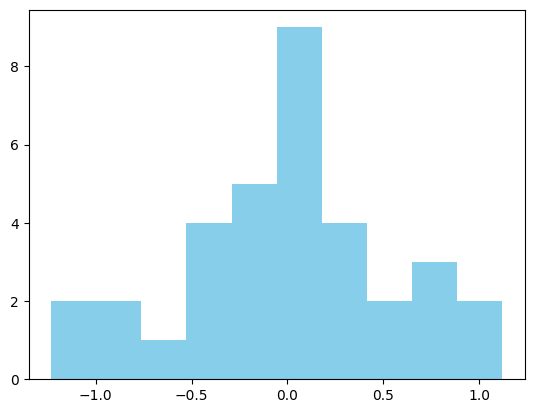

Skewness: -0.17766895870257698
Shapiro-Wilk test (p-value): 0.8450377780291557


In [ ]:
import matplotlib.pyplot as plt

plt.hist(residuals, color='skyblue')
plt.show()
import scipy.stats as stats
# Skewness test

skewness = stats.skew(residuals)
print(f"Skewness: {skewness}")

shapiro_test_result = stats.shapiro(residuals)
print(f"Shapiro-Wilk test (p-value): {shapiro_test_result[1]}")

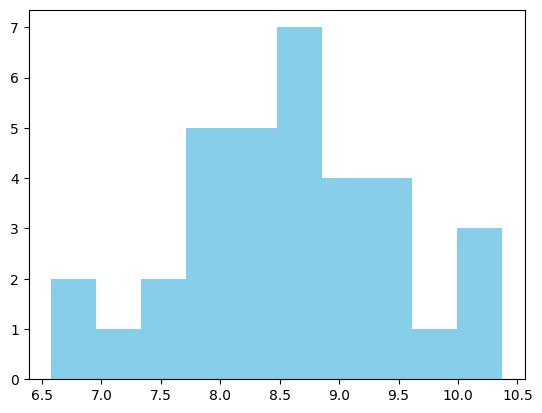

Skewness: -0.17766895870257698
Shapiro-Wilk test (p-value): 0.8022480050359442


In [ ]:
import matplotlib.pyplot as plt

plt.hist(Y, color='skyblue')
plt.show()
import scipy.stats as stats
# Skewness test

skewness = stats.skew(residuals)
print(f"Skewness: {skewness}")

shapiro_test_result = stats.shapiro(Y)
print(f"Shapiro-Wilk test (p-value): {shapiro_test_result[1]}")

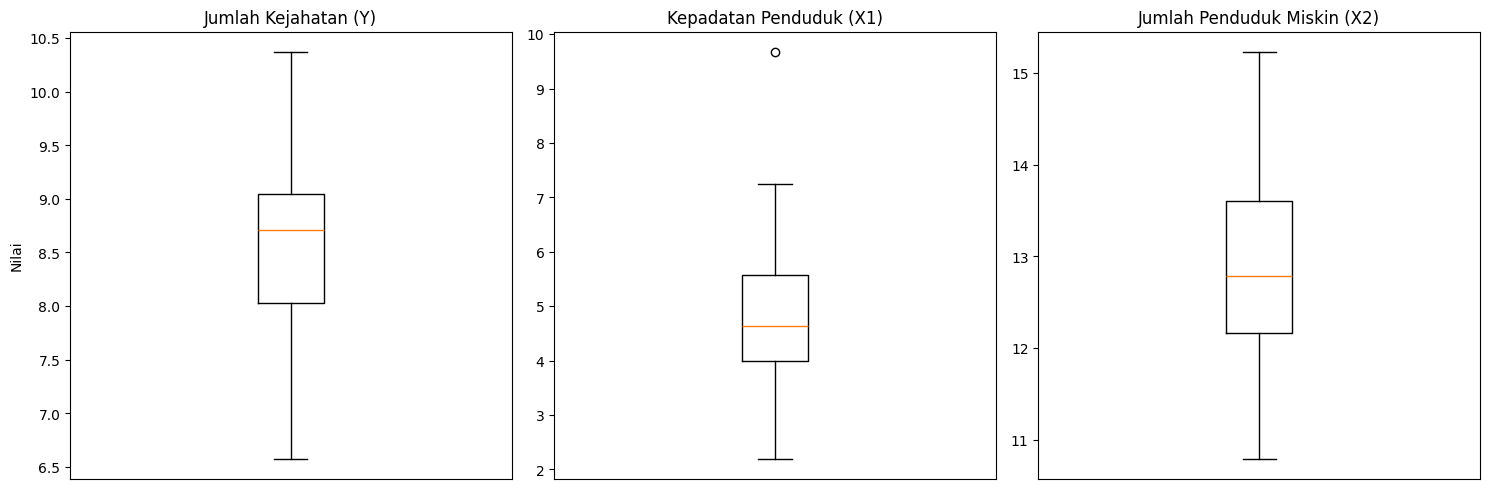

In [ ]:
import matplotlib.pyplot as plt

# Buat figure dan 3 subplot horizontal
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Boxplot 1: y (Jumlah Kejahatan)
axs[0].boxplot(y)
axs[0].set_title("Jumlah Kejahatan (Y)")
axs[0].set_ylabel("Nilai")
axs[0].set_xticks([])

# Boxplot 2: x1 (Kepadatan Penduduk)
axs[1].boxplot(x1)
axs[1].set_title("Kepadatan Penduduk (X1)")
axs[1].set_xticks([])

# Boxplot 3: x2 (Jumlah Penduduk Miskin)
axs[2].boxplot(x2)
axs[2].set_title("Jumlah Penduduk Miskin (X2)")
axs[2].set_xticks([])

# Tampilkan plot
plt.tight_layout()
plt.show()

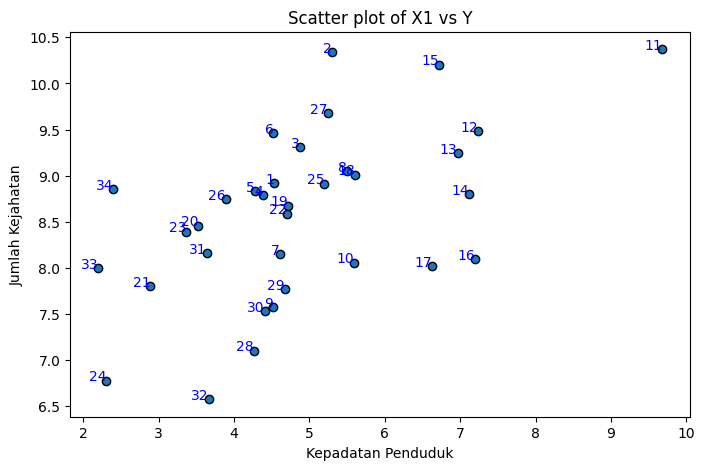

In [ ]:
# Transformasi log
x1 = np.log(data["kepadatan_penduduk"])
x2 = np.log(data["jml_penduduk_miskin"])
y = np.log(data["jml_kejahatan"])

# Scatter plot log(X1) vs log(Y)
plt.figure(figsize=(8, 5))
plt.scatter(x1,y, edgecolors="black")

# Menambahkan nomor amatan di setiap titik
for i in range(len(data)):
    plt.text(x1[i], y[i], str(i+1), fontsize=10, color="blue", ha="right")

# Label
plt.xlabel('Kepadatan Penduduk')
plt.ylabel('Jumlah Kejahatan')
plt.title('Scatter plot of X1 vs Y')
plt.show()

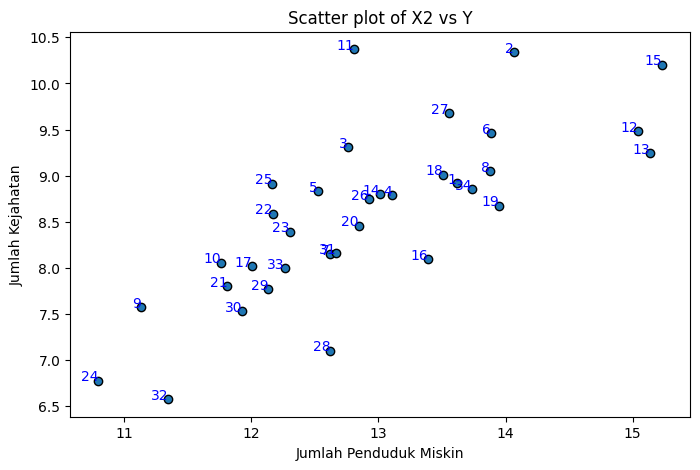

In [ ]:
# Scatter plot log(X2) vs log(Y)
plt.figure(figsize=(8, 5))
plt.scatter(x2,y, edgecolors="black")

# Menambahkan nomor amatan di setiap titik
for i in range(len(data)):
    plt.text(x2[i], y[i], str(i+1), fontsize=10, color="blue", ha="right")

# Label
plt.xlabel('Jumlah Penduduk Miskin')
plt.ylabel('Jumlah Kejahatan')
plt.title('Scatter plot of X2 vs Y')
plt.show()

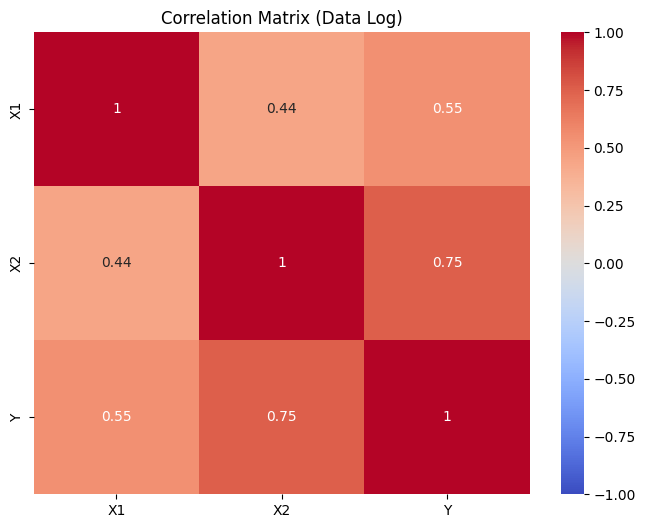

          X1        X2         Y
X1  1.000000  0.443659  0.545119
X2  0.443659  1.000000  0.751261
Y   0.545119  0.751261  1.000000


In [ ]:
# Hitung matriks korelasi
correlation_matrix_log = df_log.corr()

# Tampilkan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_log, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix (Data Log)")
plt.show()

# Tampilkan juga korelasinya di console (opsional)
print(correlation_matrix_log)


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Hanya untuk prediktor
X = df_log[['X1', 'X2']]
X = sm.add_constant(X)  # tambahkan konstanta/intersep

# Hitung VIF
vif_data = pd.DataFrame()
vif_data["Variabel"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]

print("Uji Multikolinearitas dengan VIF:")
print(vif_data)

Uji Multikolinearitas dengan VIF:
  Variabel         VIF
0    const  153.694056
1       X1    1.245072
2       X2    1.245072


### Regresi Bayesian Normal

In [ ]:
# prior
priors = {
    "Intercept":bmb.Prior("Normal", mu=0, sigma=1),
    "X1": bmb.Prior("Normal", mu=0, sigma=5),
    "X2": bmb.Prior("Normal", mu=0, sigma=5),
    "sigma": bmb.Prior("HalfCauchy", beta=5),
}
# Definisikan model menggunakan distribusi Gaussian (default)
modelBN = bmb.Model("Y ~ X1 + X2", df_log,priors=priors)
modelBN

# Estimasi parameter menggunakan MCMC (default)
traceBN = modelBN.fit(**sampler_kwargs, idata_kwargs={"log_likelihood": True})

Output()

In [ ]:
modelBN

       Formula: Y ~ X1 + X2
        Family: gaussian
          Link: mu = identity
  Observations: 34
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            X1 ~ Normal(mu: 0.0, sigma: 5.0)
            X2 ~ Normal(mu: 0.0, sigma: 5.0)
        
        Auxiliary parameters
            sigma ~ HalfCauchy(beta: 5.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
# az.summary(traceBN, round_to=5, hdi_prob=0.95)
az.summary(traceBN, var_names=["Intercept", "X1", "X2", "sigma"], round_to=5, hdi_prob=0.95)

mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
Intercept  0.77770  1.34336  -1.93643    3.25828    0.02114  0.02105   
X1         0.15059  0.07641   0.00211    0.30483    0.00134  0.00122   
X2         0.53987  0.11287   0.33982    0.78542    0.00197  0.00177   
sigma      0.62027  0.08639   0.46357    0.79094    0.00159  0.00172   

             ess_bulk    ess_tail    r_hat  
Intercept  4051.96516  3179.34496  0.99970  
X1         3260.38750  3057.53209  1.00138  
X2         3285.40663  2870.59302  1.00028  
sigma      3116.22084  2553.89721  1.00142

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'X1'}>, <Axes: title={'center': 'X1'}>],
       [<Axes: title={'center': 'X2'}>, <Axes: title={'center': 'X2'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

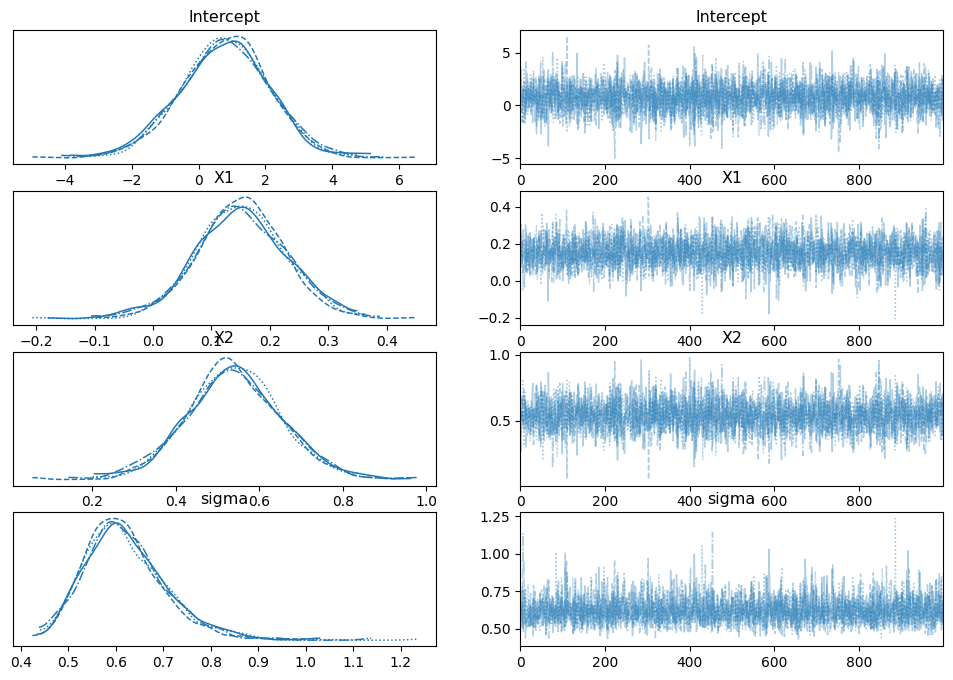

In [ ]:
az.plot_trace(traceBN)

/usr/local/lib/python3.11/dist-packages/bambi/models.py:858: FutureWarning: 'pps' has been replaced by 'response' and is not going to work in the future
  warnings.warn(


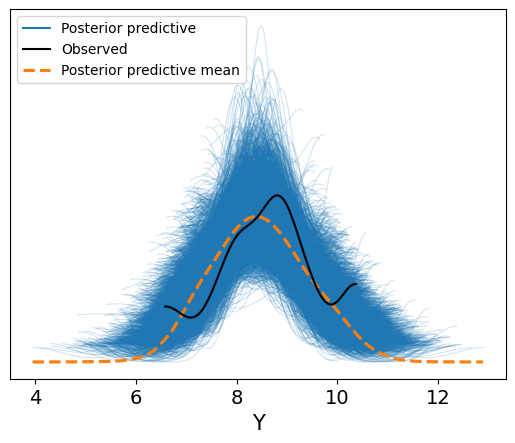

In [ ]:
# Generate Posterior Predictive Samples
ppcBN = modelBN.predict(traceBN, kind="pps", inplace=False)

az.plot_ppc(ppcBN)
plt.legend(loc='best')

In [ ]:
print(df_log["Y"].describe())
print(hash(pd.util.hash_pandas_object(df_log).sum()))

count    34.000000
mean      8.580459
std       0.921288
min       6.576470
25%       8.030937
50%       8.709746
75%       9.041375
max      10.371427
Name: Y, dtype: float64
1441572386506880139


### Regresi Bayesian FSST

In [ ]:
# prior
priors = {
    # "Intercept":bmb.Prior("Normal", mu=0, sigma=1),
    # "X1": bmb.Prior("Normal", mu=0, sigma=5),
    # "X2": bmb.Prior("Normal", mu=0, sigma=5),
    # "sigma": bmb.Prior("HalfCauchy", beta=5),
    "nu": bmb.Prior("Gamma", alpha=2, beta=2),
    "alpha": bmb.Prior("Gamma", alpha=2, beta=1.5),
}

# model regresi dengan bambi
modelBF = bmb.Model("Y ~ X1 + X2",  df_log, family=fsst_family, priors=priors)
modelBF
traceBF = modelBF.fit(**sampler_kwargs, idata_kwargs={"log_likelihood": True})

Output()

In [ ]:
print(df_log["Y"].describe())
print(hash(pd.util.hash_pandas_object(df_log).sum()))

count    34.000000
mean      8.580459
std       0.921288
min       6.576470
25%       8.030937
50%       8.709746
75%       9.041375
max      10.371427
Name: Y, dtype: float64
1441572386506880139


In [ ]:
modelBF

       Formula: Y ~ X1 + X2
        Family: fsst
          Link: mu = identity
  Observations: 34
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            X1 ~ Normal(mu: 0.0, sigma: 5.0)
            X2 ~ Normal(mu: 0.0, sigma: 5.0)
        
        Auxiliary parameters
            alpha ~ Gamma(alpha: 2.0, beta: 1.5)
            sigma ~ HalfCauchy(beta: 5.0)
            nu ~ Gamma(alpha: 2.0, beta: 2.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
az.summary(traceBF, round_to=5, hdi_prob=0.95)

mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
Intercept  0.37397  1.31256  -2.38817    2.76110    0.02863  0.02015   
X1         0.02649  0.09797  -0.16940    0.21688    0.00243  0.00177   
X2         0.59756  0.11729   0.36285    0.82571    0.00285  0.00214   
alpha      1.56954  0.48283   0.78974    2.55316    0.01308  0.01478   
nu         2.31422  0.85820   0.95549    4.10049    0.01645  0.01815   
sigma      0.41214  0.09510   0.23565    0.60087    0.00195  0.00160   

             ess_bulk    ess_tail    r_hat  
Intercept  2105.58997  2313.74721  1.00018  
X1         1643.59681  1988.40279  1.00145  
X2         1700.16935  1974.31915  1.00065  
alpha      1561.98165  1505.04823  1.00091  
nu         2554.30726  2786.40495  1.00218  
sigma      2269.88004  2038.36111  1.00150

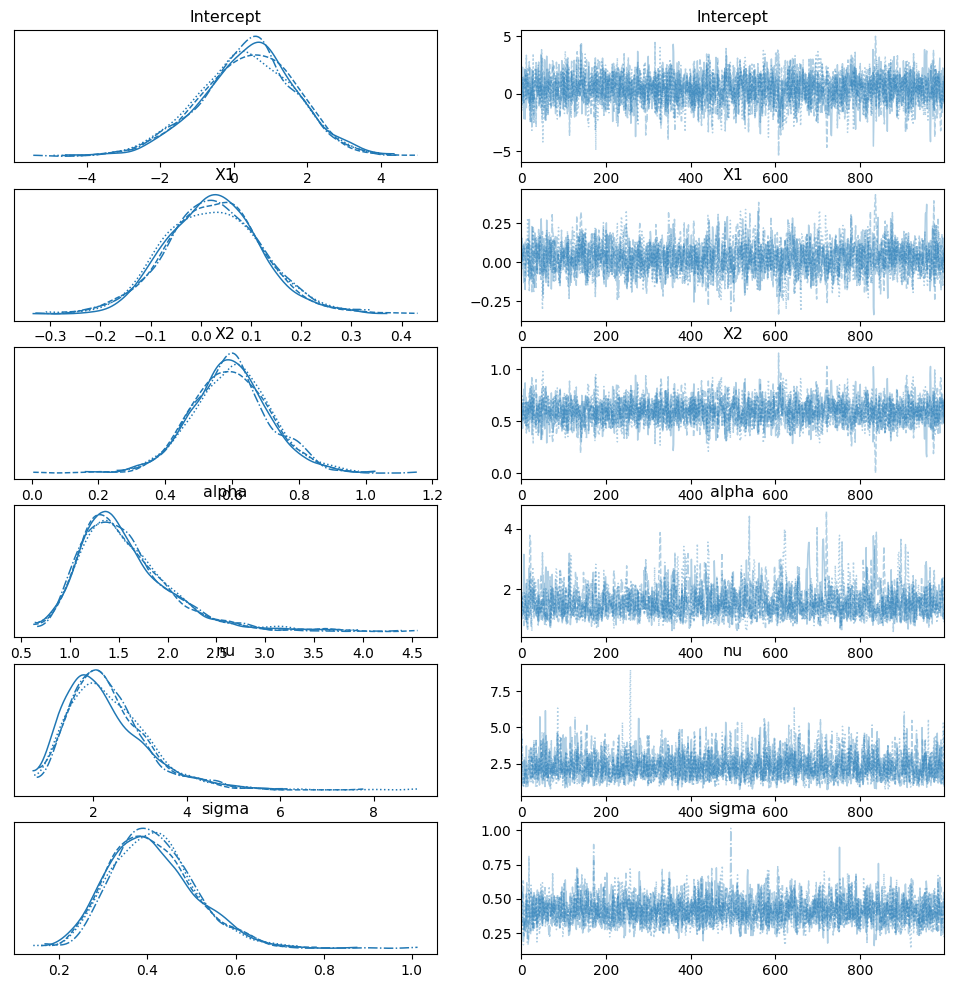

In [ ]:
az.plot_trace(traceBF)
plt.show()

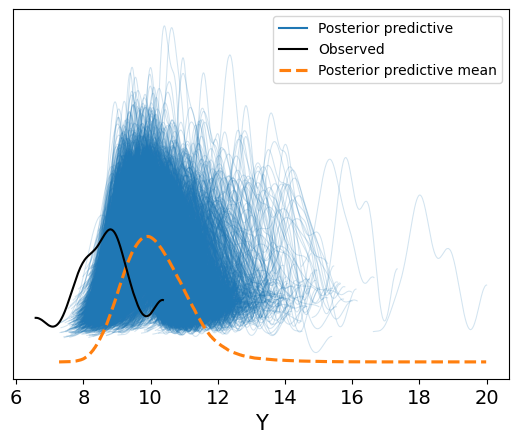

In [ ]:
ppcBF = modelBF.predict(traceBF, kind="response", inplace=False)
az.plot_ppc(ppcBF)
plt.legend(loc='best')

###Regresi Bayesian MSNBurr

Output()

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'b0'}>, <Axes: title={'center': 'b0'}>],
       [<Axes: title={'center': 'b1'}>, <Axes: title={'center': 'b1'}>],
       [<Axes: title={'center': 'b2'}>, <Axes: title={'center': 'b2'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

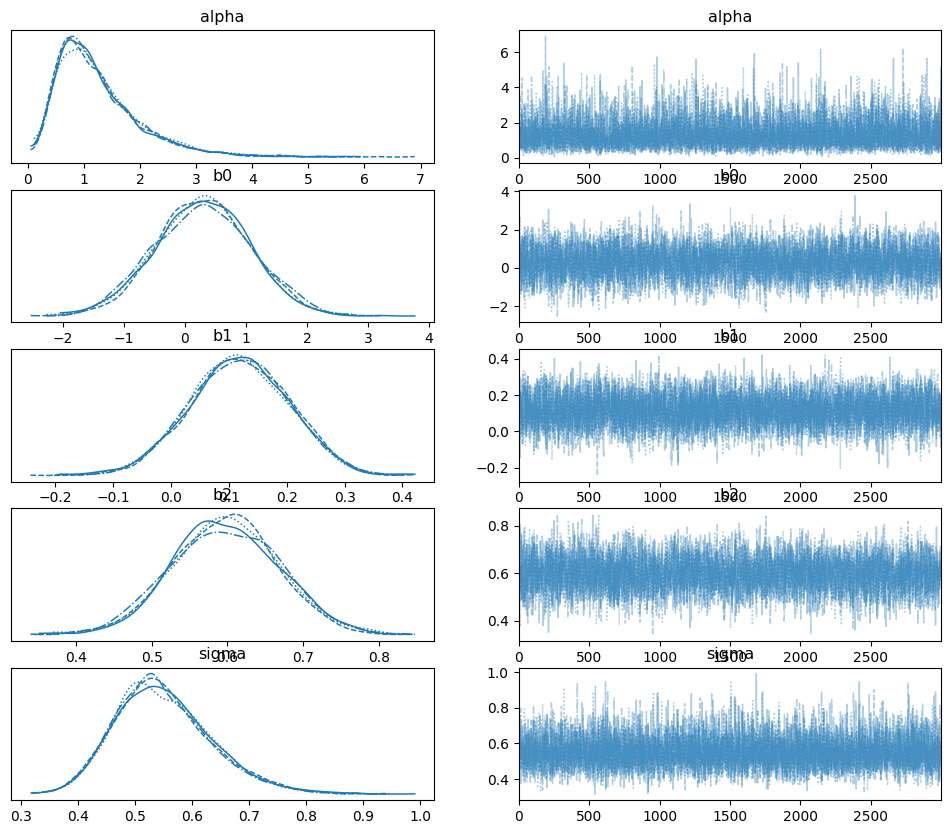

In [ ]:
x1 = np.log(data["kepadatan_penduduk"])
x2 = np.log(data["jml_penduduk_miskin"])
y = np.log(data["jml_kejahatan"])


with pm.Model() as regresimsnburr:
    sigma = pm.HalfCauchy('sigma',5)
    alpha = pm.Gamma('alpha',2,1.5)
    b0 = pm.Normal('b0',0, 1)
    b1 = pm.Normal('b1',0, 5)
    b2 = pm.Normal('b2',0, 5)

    eps = b0 + b1*x1 + b2*x2

    msnburr('Regresi MSNBurr', mu=eps, sigma=sigma, alpha=alpha, observed=y)
    step = pm.NUTS(target_accept=0.95, max_treedepth=15)
    trace2 = pm.sample(3000, step=step, chains=4, cores=4,return_inferencedata=True, random_seed=42, tune=2000)

az.plot_trace(trace2)

In [ ]:
az.summary(trace2, round_to=5, hdi_prob=0.95)

mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd    ess_bulk  \
alpha  1.25020  0.75114   0.19846    2.77991    0.00837  0.00971  7455.48893   
b0     0.29721  0.78418  -1.27820    1.78513    0.01073  0.00815  5338.70173   
b1     0.11765  0.08559  -0.04680    0.28266    0.00108  0.00081  6235.04307   
b2     0.59798  0.07033   0.46266    0.73693    0.00099  0.00072  5012.73534   
sigma  0.55067  0.08522   0.38977    0.71827    0.00097  0.00091  7873.98649   

         ess_tail    r_hat  
alpha  6761.75058  1.00027  
b0     6403.31467  1.00043  
b1     6753.61484  1.00103  
b2     6186.99393  1.00139  
sigma  6815.75767  1.00064

Output()

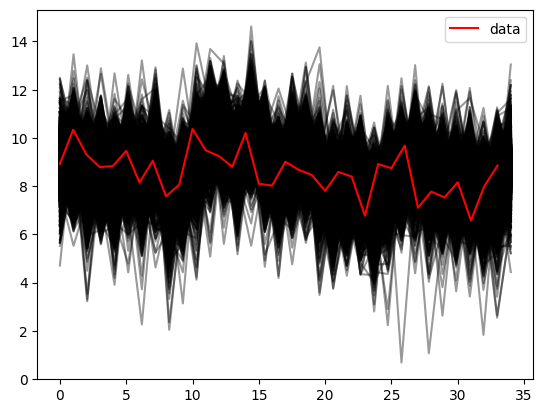

In [ ]:
with regresimsnburr:
    # Draw samples from posterior predictive
    post_pred = pm.sample_posterior_predictive(trace2)
    trace2.extend(post_pred)

Y = np.log(data["jml_kejahatan"])
fig, ax = plt.subplots()
x = xr.DataArray(np.linspace(0, 34, 34), dims=["plot_dim"])
y = trace2.posterior_predictive['Regresi MSNBurr']

ax.plot(x, y.stack(sample=("chain","draw")).values.squeeze(), c="k", alpha=0.4)
ax.plot(Y, color="r", label="data")
ax.legend();

In [ ]:
summary = az.summary(trace, round_to=3)
mean_values = summary['mean']
y_pred = mean_values[0] + mean_values[1]*x1
residuals = y - y_pred
plt.hist(residuals, edgecolor='black')
plt.title('PDRB ADHK')
plt.xlabel('Nilai')
plt.ylabel('Frekuensi')
plt.show()

In [ ]:
# prior
priors = {
    "Intercept":bmb.Prior("Normal", mu=0, sigma=1),
    "X1": bmb.Prior("Normal", mu=0, sigma=5),
    "X2": bmb.Prior("Normal", mu=0, sigma=5),
    "sigma": bmb.Prior("HalfCauchy", beta=5),
    "alpha": bmb.Prior("Gamma", alpha=2, beta=1.5),
}

# model regresi dengan bambi
modelBM = bmb.Model("Y ~ X1 + X2",  df_log, family=msnburr_family, priors=priors)
modelBM
traceBM = modelBM.fit(**sampler_kwargs, idata_kwargs={"log_likelihood": True})

Output()

In [ ]:
az.summary(traceBM, round_to=5, hdi_prob=0.95)

mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
Intercept  0.64526  1.30744  -1.94112    3.23374    0.02222  0.01859   
X1         0.09637  0.08800  -0.07668    0.26697    0.00168  0.00131   
X2         0.56669  0.11319   0.35288    0.79892    0.00214  0.00175   
alpha      1.75787  0.91084   0.36850    3.60020    0.01663  0.01962   
sigma      0.57219  0.09039   0.40949    0.75958    0.00162  0.00139   

             ess_bulk    ess_tail    r_hat  
Intercept  3453.66246  3242.21408  1.00041  
X1         2736.29852  2932.47335  1.00006  
X2         2796.84272  2760.28694  1.00069  
alpha      2714.58029  2198.43975  1.00123  
sigma      3134.24737  3161.68190  1.00103

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'X1'}>, <Axes: title={'center': 'X1'}>],
       [<Axes: title={'center': 'X2'}>, <Axes: title={'center': 'X2'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

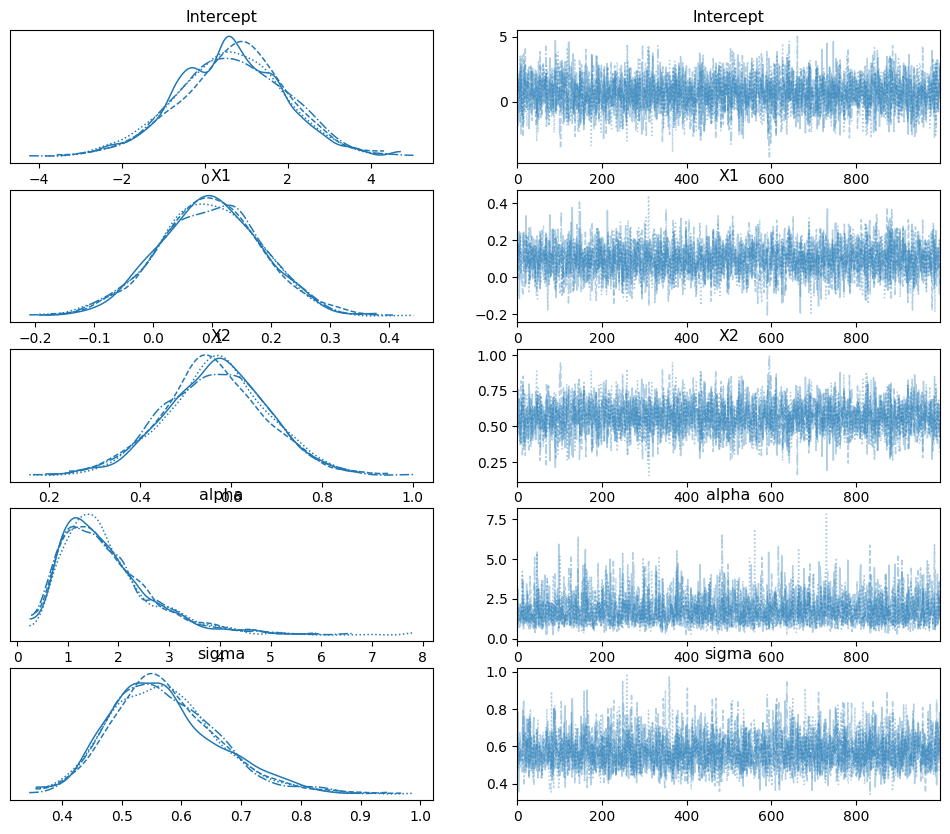

In [ ]:
az.plot_trace(traceBM)

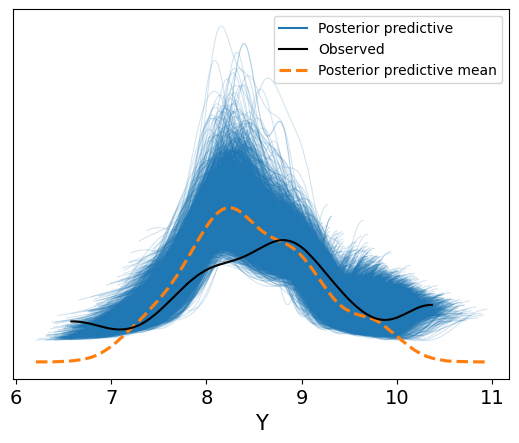

In [ ]:
ppcBM = modelBM.predict(traceBM, kind="response", inplace=False)
az.plot_ppc(ppcBM)
plt.legend(loc='best')

###Regresi Bayesian MSNBurr-IIa

In [ ]:
# prior
priors = {
    "Intercept":bmb.Prior("Normal", mu=0, sigma=1),
    "X1": bmb.Prior("Normal", mu=0, sigma=5),
    "X2": bmb.Prior("Normal", mu=0, sigma=5),
    "sigma": bmb.Prior("HalfCauchy", beta=5),
    "alpha": bmb.Prior("Gamma", alpha=2, beta=1.5),
}

# model regresi dengan bambi
modelBM2 = bmb.Model("Y ~ X1 + X2",  df_log, family=msnburr_iia_family, priors=priors)
modelBM2
traceBM2 = modelBM2.fit(**sampler_kwargs, idata_kwargs={"log_likelihood": True})

Output()

In [ ]:
az.summary(traceBM2, round_to=5, hdi_prob=0.95)

mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
Intercept  0.66041  1.27598  -1.88955    3.05699    0.02182  0.01989   
X1         0.09742  0.09199  -0.07687    0.27959    0.00179  0.00141   
X2         0.56665  0.11035   0.36193    0.78151    0.00206  0.00194   
alpha      0.98641  0.65016   0.16246    2.29570    0.01271  0.01789   
sigma      0.55904  0.09341   0.38698    0.74225    0.00176  0.00178   

             ess_bulk    ess_tail    r_hat  
Intercept  3459.96559  2729.14263  1.00129  
X1         2644.92618  2764.20969  1.00281  
X2         2921.30542  2305.38271  1.00115  
alpha      2607.72862  2461.14234  1.00027  
sigma      2752.50242  2245.83737  1.00103

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'X1'}>, <Axes: title={'center': 'X1'}>],
       [<Axes: title={'center': 'X2'}>, <Axes: title={'center': 'X2'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

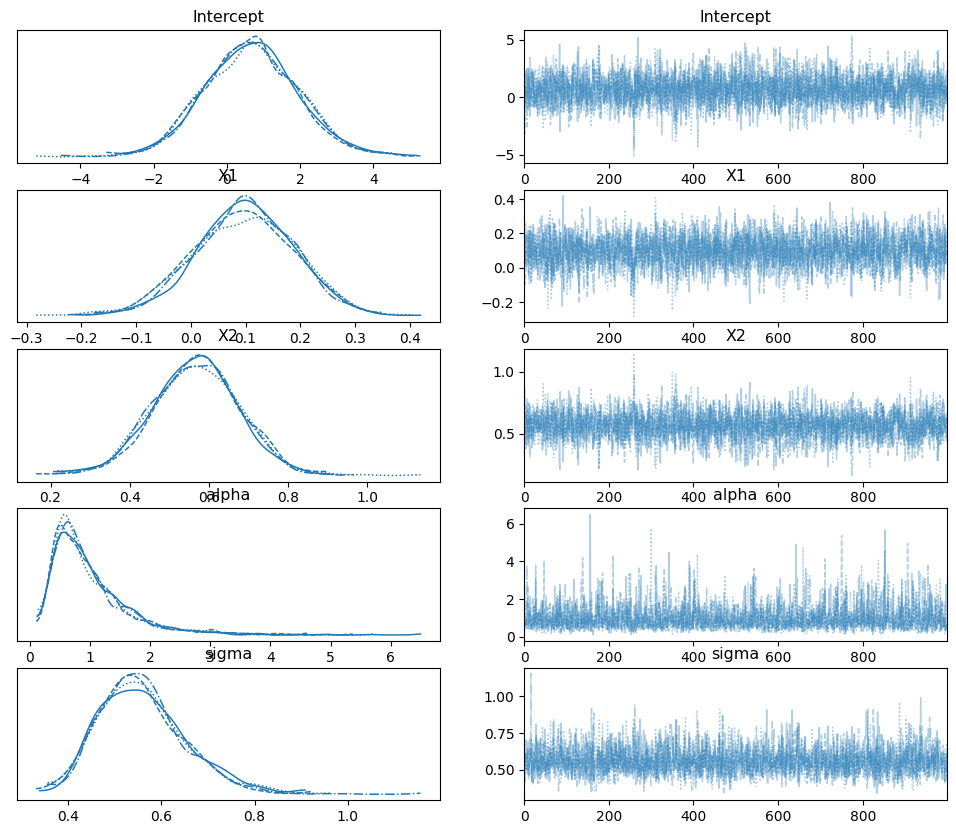

In [ ]:
az.plot_trace(traceBM2)

/usr/local/lib/python3.11/dist-packages/bambi/models.py:858: FutureWarning: 'pps' has been replaced by 'response' and is not going to work in the future
  warnings.warn(


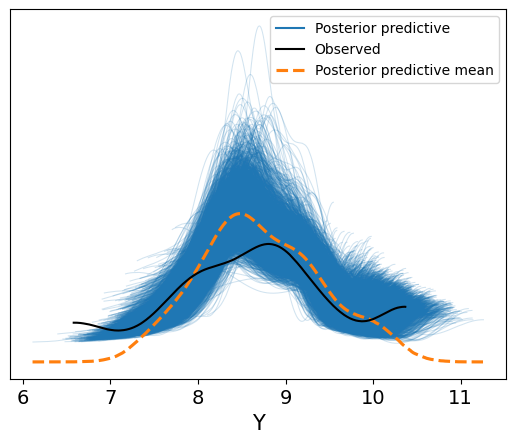

In [ ]:
ppcBM2 = modelBM2.predict(traceBM2, kind="pps", inplace=False)
az.plot_ppc(ppcBM2)
plt.legend(loc='best')

### Cek Kebaikan Model

In [ ]:
loo_normal = az.loo(traceBN, pointwise=True)
k_vals = loo_normal.pareto_k
print("Jumlah observasi bermasalah:", (k_vals > 0.7).sum())
print("Index observasi k > 0.7:", np.where(k_vals > 0.7)[0])


Jumlah observasi bermasalah: <xarray.DataArray 'pareto_shape' ()> Size: 8B
array(1)
Index observasi k > 0.7: [10]


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: xlabel='Data Point', ylabel='Shape parameter k'>

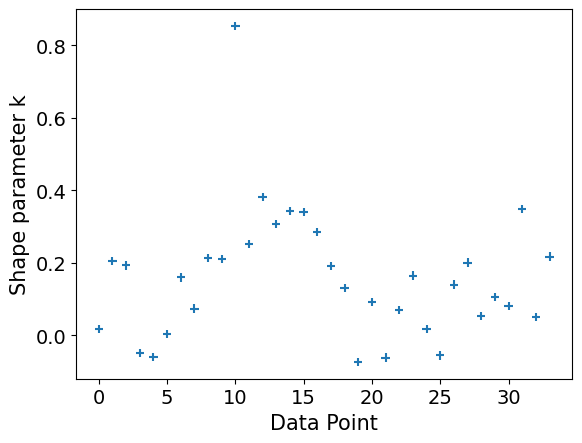

In [ ]:
az.plot_khat(loo_normal)


In [ ]:
df_comp_loo = az.compare(
    {"Normal": traceBN, "FSST": traceBF, "MSNBurr": traceBM, "MSNBurr-IIa": traceBM2},
    method="stacking"  # atau "bb-pseudo-BMA"
)
df_comp_loo

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank   elpd_loo     p_loo  elpd_diff        weight        se  \
Normal          0 -34.089647  4.672983   0.000000  9.015337e-01  4.447158   
MSNBurr         1 -34.271696  4.696989   0.182049  9.846629e-02  4.605579   
MSNBurr-IIa     2 -34.517588  5.062782   0.427941  0.000000e+00  4.672251   
FSST            3 -37.540536  6.130434   3.450889  1.110223e-16  4.718997   

                  dse  warning scale  
Normal       0.000000     True   log  
MSNBurr      0.686424    False   log  
MSNBurr-IIa  0.772611    False   log  
FSST         1.753929    False   log

In [ ]:
az.compare({"Normal": traceBN, "FSST": traceBF, "MSNBurr":traceBM, "MSNBurr-IIa": traceBM2})

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank   elpd_loo     p_loo  elpd_diff        weight        se  \
Normal          0 -34.089647  4.672983   0.000000  9.015337e-01  4.447158   
MSNBurr         1 -34.271696  4.696989   0.182049  9.846629e-02  4.605579   
MSNBurr-IIa     2 -34.517588  5.062782   0.427941  0.000000e+00  4.672251   
FSST            3 -37.540536  6.130434   3.450889  1.110223e-16  4.718997   

                  dse  warning scale  
Normal       0.000000     True   log  
MSNBurr      0.686424    False   log  
MSNBurr-IIa  0.772611    False   log  
FSST         1.753929    False   log

In [ ]:
waic = az.waic(traceBN)
loo = az.loo(traceBN)

print(waic)
print(loo)

Computed from 4000 posterior samples and 34 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -33.76     4.25
p_waic        4.34        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 34 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -34.09     4.45
p_loo        4.67        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       33   97.1%
   (0.70, 1]   (bad)         1    2.9%
   (1, Inf)   (very bad)    0    0.0%



/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [ ]:
waic = az.waic(traceBF)
loo = az.loo(traceBF)

print(waic)
print(loo)

Computed from 4000 posterior samples and 34 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -37.47     4.71
p_waic        6.06        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 34 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -37.54     4.72
p_loo        6.13        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       34  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [ ]:
waic = az.waic(traceBM)
loo = az.loo(traceBM)

print(waic)
print(loo)

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 34 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -34.19     4.58
p_waic        4.62        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 34 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -34.27     4.61
p_loo        4.70        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       34  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [ ]:
waic = az.waic(traceBM2)
loo = az.loo(traceBM2)

print(waic)
print(loo)

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 34 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -34.41     4.63
p_waic        4.95        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 34 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -34.52     4.67
p_loo        5.06        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       34  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



#PERBEDAAN PYMC DAN BAMBI

In [ ]:
import pandas as pd
import numpy as np

# Contoh dataset
np.random.seed(42)
n = 100
x = np.random.normal(0, 1, n)
y = 1.5 * x + np.random.normal(0, 1, n)
data = pd.DataFrame({'x': x, 'y': y})


In [ ]:
import pymc as pm
import pytensor.tensor as pt

with pm.Model() as pymc_model:
    # Priors
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Likelihood
    mu = alpha + beta * data["x"].values
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=data["y"].values)

    # Inference
    pymc_trace = pm.sample(1000, tune=1000, return_inferencedata=True, target_accept=0.95)


Output()

In [ ]:
import bambi as bmb

# Model Bambi, menggunakan prior yang sama
bambi_model = bmb.Model(
    "y ~ x",
    data=data,
    priors={
        "Intercept": bmb.Prior("Normal", mu=0, sigma=10),
        "x": bmb.Prior("Normal", mu=0, sigma=10),
        "sigma": bmb.Prior("HalfNormal", sigma=1),
    },
)

# Inference
bambi_trace = bambi_model.fit(draws=1000, tune=1000, target_accept=0.95)


Output()

In [ ]:
az.summary(pymc_trace, round_to=5, hdi_prob=0.95)

mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd    ess_bulk  \
alpha  0.01022  0.09680  -0.17185    0.20464    0.00219  0.00297  1931.59725   
beta   1.35545  0.10434   1.16495    1.55628    0.00265  0.00227  1556.42784   
sigma  0.95890  0.07059   0.82722    1.09341    0.00165  0.00177  1873.13495   

         ess_tail    r_hat  
alpha  1284.61445  1.00033  
beta   1143.25176  1.00687  
sigma  1169.13177  1.00052

In [ ]:
az.summary(bambi_trace, round_to=5, hdi_prob=0.95)

mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
Intercept  0.00975  0.10062  -0.18272    0.20780     0.0023  0.00228   
sigma      0.95843  0.07098   0.82657    1.10206     0.0016  0.00182   
x          1.35980  0.10668   1.15129    1.57185     0.0024  0.00274   

             ess_bulk    ess_tail    r_hat  
Intercept  1904.12089  1135.52120  0.99946  
sigma      1972.53935  1329.35663  1.00101  
x          1982.17792  1047.54872  1.00120

PyMC:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.010  0.097  -0.170    0.190      0.002    0.003    1932.0    1285.0   
beta   1.355  0.104   1.163    1.542      0.003    0.002    1556.0    1143.0   
sigma  0.959  0.071   0.827    1.084      0.002    0.002    1873.0    1169.0   

       r_hat  
alpha   1.00  
beta    1.01  
sigma   1.00  

Bambi:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  0.010  0.101  -0.182    0.192      0.002    0.002    1904.0   
x          1.360  0.107   1.152    1.560      0.002    0.003    1982.0   
sigma      0.958  0.071   0.816    1.080      0.002    0.002    1973.0   

           ess_tail  r_hat  
Intercept    1136.0    1.0  
x            1048.0    1.0  
sigma        1329.0    1.0  


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

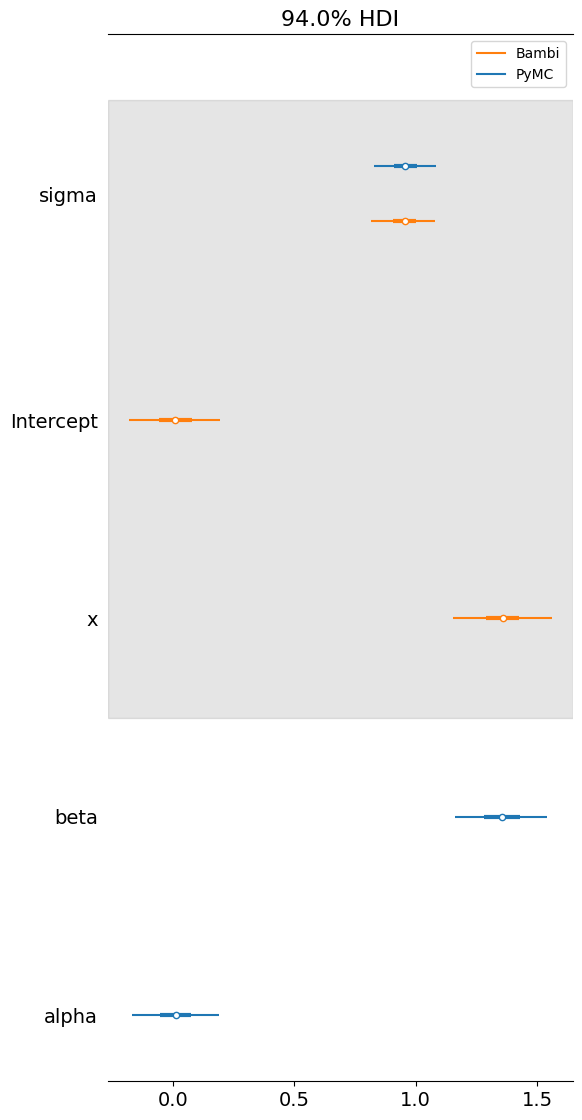

In [ ]:
import arviz as az

# Ringkasan statistik posterior
print("PyMC:")
print(az.summary(pymc_trace, var_names=["alpha", "beta", "sigma"]))

print("\nBambi:")
print(az.summary(bambi_trace, var_names=["Intercept", "x", "sigma"]))

# Plot perbandingan
az.plot_forest([pymc_trace, bambi_trace], model_names=["PyMC", "Bambi"], combined=True)
